# Small-model report

On the small model (L=2, H=4):

- Replication of Raventós et al. (2023) + fitting the various algorithms
- All the analyses (RLCT, PCA, Attention Entropies, Covariance, Weight-staring). 

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

if not "AWS_ACCESS_KEY_ID" in os.environ or not "AWS_SECRET_ACCESS_KEY" in os.environ:
    raise Exception("AWS_ACCESS_KEY_ID or AWS_SECRET_ACCESS_KEY not found in environment variables. Please set them in .env file.")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pp
from pathlib import Path
from typing import Optional, Iterable, List, Tuple, Dict, Union, Callable

import seaborn as sns
import pandas as pd
from tqdm import tqdm
import torch 
from torch import nn

import devinterp
import devinfra

from icl.analysis.utils import get_unique_run

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
sns.set_theme(style="whitegrid")

SWEEP_ID = "6g954fkg"
SWEEP_FILENAME = "small-sweep-2.yaml"
FIGURES=Path("../figures")
ANALYSIS = Path("../analysis")

DEVICE = devinfra.utils.device.get_default_device()
DEVICE

device(type='mps')

## Set-up

In [4]:
from icl.analysis.utils import get_sweep_configs

filters = {"task_config": {"num_layers": 2, "num_heads": 4}, "optimizer_config": {"lr": 0.01}}  # TODO: Where are the H=2 runs?
configs = list(get_sweep_configs(f"../sweeps/{SWEEP_FILENAME}", **filters))

print(f"Found {len(configs)} runs.")

Found 21 runs.


/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/Users/Jesse/Projects/devinfra/devinfra/utils/iterables.py:29: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(


In [5]:
# Figure out which checkpoints are available

checkpointers = [config.checkpointer_config.factory() for config in tqdm(configs, desc="Reading checkpoints")]

for checkpointer in tqdm(checkpointers, desc="Loading checkpoints"):
    print(f"Found {len(checkpointer.file_ids)} checkpoints for {checkpointer}")

Loading checkpoints: 100%|██████████| 21/21 [00:00<00:00, 27026.81it/s]

Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-1-task-c19845-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-2-task-7ed30b-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-4-task-871f4f-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-8-task-6d414c-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-16-task-fef7aa-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-32-task-b02901-opt-aa689f-sched-1ee2ae)])
Found 96 checkpoints for CompositeStorageProvider([S3StorageProvider(s3://devinterp/checkpoints/icl/ntasks-64-

## Replication 

In [6]:
import wandb
from devinfra.utils.iterables import filter_objs

api= wandb.Api()
sweep = api.sweep(f"devinterp/icl/{SWEEP_ID}")
runs = list(filter_objs([r for r in sweep.runs], config=filters))

print(f"Found {len(runs)} runs.")

Found 21 runs.


In [ ]:
from devinfra.utils.iterables import flatten_dict
from icl.analysis.utils import wandb_runs_to_df

df = wandb_runs_to_df(runs)

In [ ]:
pp(list(df.columns))

df

In [ ]:
def recreate_fig_2(df, title=""):
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Set title

    # Set common labels
    fig.text(0.08, 0.5, r'$\mathcal{T}_\mathrm{Pretrain}$', va='center', rotation='vertical', fontsize=14)
    fig.text(0.08, 0.26, r'$\mathcal{T}_\mathrm{True}$', va='center', rotation='vertical', fontsize=14)

    grouped_by_num_tasks = df.groupby('task_config/num_tasks')

    # Within each group, find the row with the last step
    last_rows = grouped_by_num_tasks.apply(lambda g: g[g._step == g._step.max() & g["pretrain/mse"].notna()])

    # Ungroup
    last_rows = last_rows.reset_index(drop=True)
    print(last_rows)

    # Top row
    sns.lineplot(x='task_config/num_tasks', y='pretrain/mse', data=last_rows, ax=axs[0, 0], hue='_step')
    sns.lineplot(x='task_config/num_tasks', y='pretrain/delta_dmmse', data=last_rows, ax=axs[0, 1], hue='_step')
    sns.lineplot(x='task_config/num_tasks', y='pretrain/delta_ridge', data=last_rows, ax=axs[0, 2], hue='_step')

    # Bottom row
    sns.lineplot(x='task_config/num_tasks', y='true/mse', data=last_rows, ax=axs[1, 0], hue='_step')
    sns.lineplot(x='task_config/num_tasks', y='true/delta_dmmse', data=last_rows, ax=axs[1, 1], hue='_step')
    sns.lineplot(x='task_config/num_tasks', y='true/delta_ridge', data=last_rows, ax=axs[1, 2], hue='_step')

    # Y-labels for first column
    axs[0, 0].set_ylabel('MSE')
    axs[1, 0].set_ylabel('MSE')

    # Y-labels for second column
    axs[0, 1].set_ylabel(r'$\Delta_\mathrm{PT dMMSE}$')
    axs[1, 1].set_ylabel(r'$\Delta_\mathrm{PT dMMSE}$')

    # Y-labels for third column
    axs[0, 2].set_ylabel(r'$\Delta_\mathrm{PT Ridge}$')
    axs[1, 2].set_ylabel(r'$\Delta_\mathrm{PT Ridge}$')

    for i in range(3):
        axs[1, i].set_xlabel("# Pretraining Tasks")

    for ax in axs.flat:
        ax.set_xscale("log")

    # Hide x-labels for the top row
    for ax in axs[0, :]:
        ax.set_xlabel('')

    plt.tight_layout(rect=[0.1, 0.1, 1, 1])
    plt.show()

def recreate_fig_2_over_time(df, title=""):
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Set title
    plt.suptitle(title)

    # Set common labels
    fig.text(0.08, 0.5, r'$\mathcal{T}_\mathrm{Pretrain}$', va='center', rotation='vertical', fontsize=14)
    fig.text(0.08, 0.26, r'$\mathcal{T}_\mathrm{True}$', va='center', rotation='vertical', fontsize=14)

    cmap = sns.color_palette("viridis", as_cmap=True)

    # Top row
    sns.scatterplot(x='task_config/num_tasks', y='pretrain/mse', data=df, ax=axs[0, 0], hue='_step', palette=cmap)
    sns.scatterplot(x='task_config/num_tasks', y='pretrain/delta_dmmse', data=df, ax=axs[0, 1], hue='_step', palette=cmap)
    sns.scatterplot(x='task_config/num_tasks', y='pretrain/delta_ridge', data=df, ax=axs[0, 2], hue='_step', palette=cmap)

    # Bottom row
    sns.scatterplot(x='task_config/num_tasks', y='true/mse', data=df, ax=axs[1, 0], hue='_step', palette=cmap)
    sns.scatterplot(x='task_config/num_tasks', y='true/delta_dmmse', data=df, ax=axs[1, 1], hue='_step', palette=cmap)
    sns.scatterplot(x='task_config/num_tasks', y='true/delta_ridge', data=df, ax=axs[1, 2], hue='_step', palette=cmap)

    # Y-labels for first column
    axs[0, 0].set_ylabel('MSE')
    axs[1, 0].set_ylabel('MSE')

    # Y-labels for second column
    axs[0, 1].set_ylabel(r'$\Delta_\mathrm{PT dMMSE}$')
    axs[1, 1].set_ylabel(r'$\Delta_\mathrm{PT dMMSE}$')

    # Y-labels for third column
    axs[0, 2].set_ylabel(r'$\Delta_\mathrm{PT Ridge}$')
    axs[1, 2].set_ylabel(r'$\Delta_\mathrm{PT Ridge}$')

    for i in range(3):
        axs[1, i].set_xlabel("# Pretraining Tasks")

    for ax in axs.flat:
        ax.set_xscale("log")

    # Hide x-labels for the top row
    for ax in axs[0, :]:
        ax.set_xlabel('')

    plt.tight_layout(rect=[0.1, 0.1, 1, 1])
    plt.show()

# TODO: Add baselines (also make comparisons for other hyperparameters besides batch_size). 
# recreate_fig_2_over_time(df, title="Over training")
# recreate_fig_2(df, title="At the end")

## Fitting

In [44]:
run = Run(configs[0])
sum(p.numel() for p in run.model.parameters())

43525

In [38]:
from icl.baselines import dmmse_predictor, ridge_predictor
from icl.tasks import TaskDistribution, DiscreteTaskDistribution, RegressionSequenceDistribution

class DMMSE(nn.Module):
    def __init__(self, dist: RegressionSequenceDistribution, noise_variance: float, learn_prior: bool = False):
        super().__init__()

        self.prior = dist.task_distribution
        self.noise_variance = nn.Parameter(torch.tensor(noise_variance))

        if learn_prior:
            self.tasks = nn.Parameter(self.prior.tasks)
            self.prior.tasks = self.tasks
    
    def forward(self, xs, ys):
        return dmmse_predictor(xs, ys, self.prior, self.noise_variance)


class Ridge(nn.Module):
    def __init__(self, noise_variance: float):
        super().__init__()

        self.noise_variance = nn.Parameter(torch.tensor(noise_variance))


    def forward(self, xs, ys):
        return ridge_predictor(xs, ys, self.noise_variance)


def fit_baseline_predictor(baseline: nn.Module, model: nn.Module, dist: RegressionSequenceDistribution, num_steps: int=1000, lr: float=0.0001, device: str = "cpu", batch_size=128, num_examples=8, verbose=True):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We're fitting just a single parameter (the noise variance)

    if verbose:
        losses = []
        sigmas = []

    for step in tqdm(range(num_steps), desc="Fitting..."):
        optimizer.zero_grad()

        # Get a batch of data
        xs, ys = dist.get_batch(batch_size=batch_size, num_examples=num_examples)
        xs = xs.to(device)
        ys = ys.to(device)

        # Get the predictions of the reference model
        with torch.no_grad():
            yhats = model(xs, ys)

        # Get the predictions of the baseline
        baseline_preds = baseline(xs, ys)

        # Update the baseline to be closer to the reference model
        loss = criterion(baseline_preds, yhats)
        loss.backward()
        optimizer.step()

        if verbose:
            losses.append(loss.item())
            sigmas.append(baseline.noise_variance.item())

    if verbose:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        plt.suptitle(f"Baseline fitting {baseline.__class__.__name__} on {dist.task_distribution.__class__.__name__}")
        axes[0].plot(losses)
        axes[0].set_title("Loss")
        axes[1].plot(sigmas)
        axes[1].set_title("Noise variance")
        plt.show()

    return baseline

def eval_delta_predictor(baseline: nn.Module, model: nn.Module, xs, ys, device: str = "cpu"):
    baseline_preds = baseline(xs, ys)
    preds = model(xs, ys)

    return nn.MSELoss()(baseline_preds, preds)

Evaluating L2-H4-M1-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000


Fitting...: 100%|██████████| 200/200 [00:02<00:00, 69.96it/s]


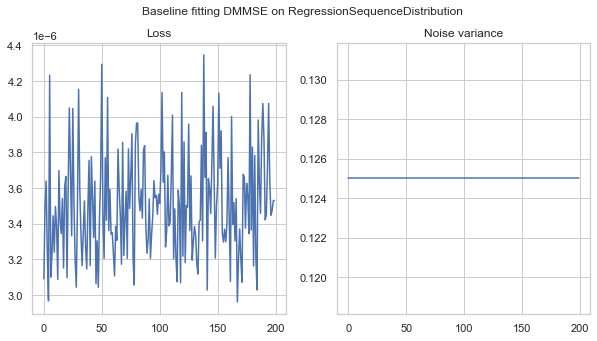

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 73.34it/s]


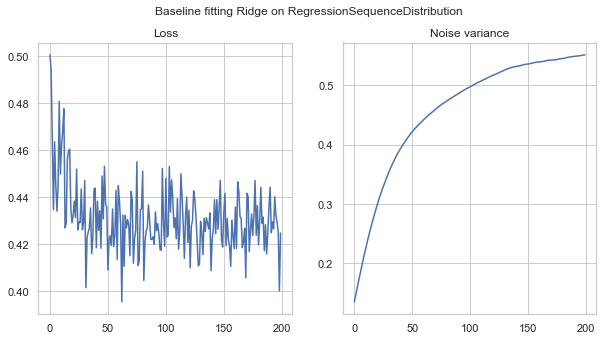

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 76.00it/s]


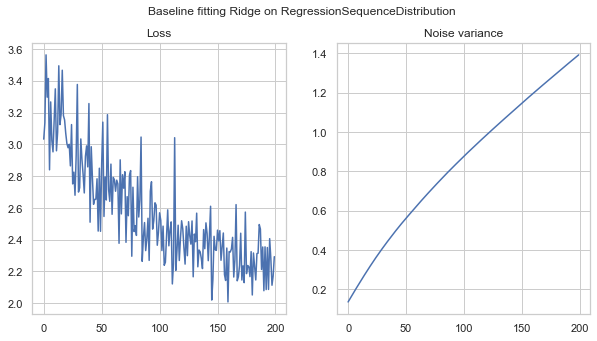

{'step': 499999,
 'config': 'L2-H4-M1-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 3.264151700932416e-06,
 'learned_ridge_pretrain/init_delta': 0.4832388162612915,
 'learned_ridge_true/init_delta': 3.371896505355835,
 'learned_dmmse_pretrain/delta': 3.264151700932416e-06,
 'learned_ridge_pretrain/delta': 0.42465826869010925,
 'learned_ridge_true/delta': 2.1970863342285156,
 'learned_dmmse_pretrain/delta_delta': 0.0,
 'learned_ridge_pretrain/delta_delta': -0.05858054757118225,
 'learned_ridge_true/delta_delta': -1.1748101711273193,
 'learned_dmmse_pretrain/noise_variance': 0.125,
 'learned_ridge_pretrain/noise_variance': 0.5514147877693176,
 'learned_ridge_true/noise_variance': 1.3923718929290771,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 1,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 'true_seed': 2,
 'sampling_seed':

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 62.62it/s]


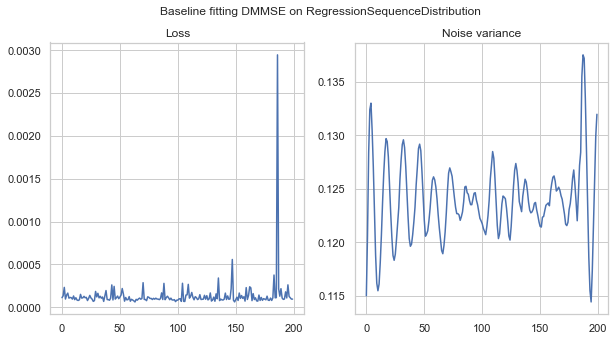

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 65.18it/s]


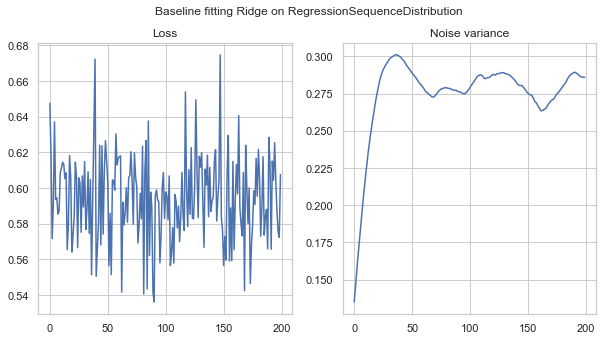

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 68.84it/s]


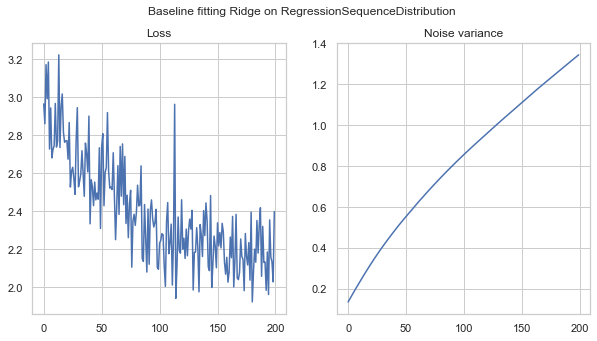

{'step': 499999,
 'config': 'L2-H4-M2-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 8.301938942167908e-05,
 'learned_ridge_pretrain/init_delta': 0.613684892654419,
 'learned_ridge_true/init_delta': 3.179323434829712,
 'learned_dmmse_pretrain/delta': 0.00011114925291622058,
 'learned_ridge_pretrain/delta': 0.5905047655105591,
 'learned_ridge_true/delta': 2.1415343284606934,
 'learned_dmmse_pretrain/delta_delta': 2.8129863494541496e-05,
 'learned_ridge_pretrain/delta_delta': -0.023180127143859863,
 'learned_ridge_true/delta_delta': -1.0377891063690186,
 'learned_dmmse_pretrain/noise_variance': 0.13195674121379852,
 'learned_ridge_pretrain/noise_variance': 0.2859148383140564,
 'learned_ridge_true/noise_variance': 1.343845009803772,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 2,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 '

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 72.25it/s]


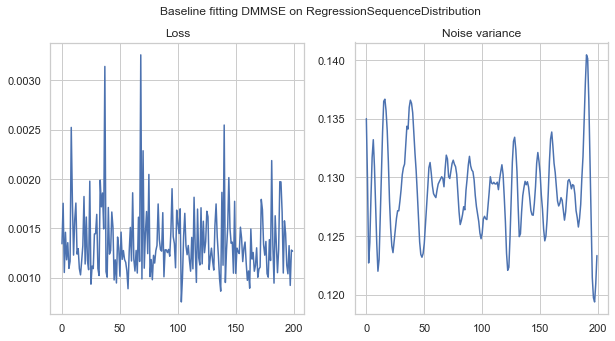

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 71.05it/s]


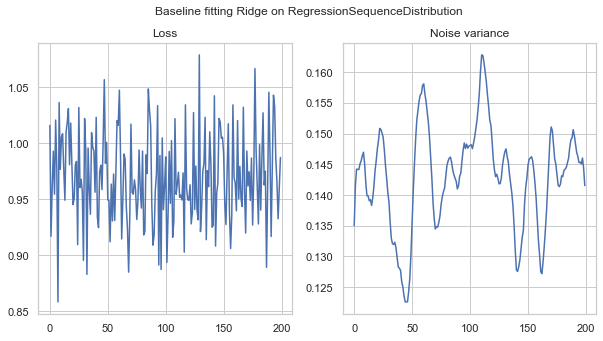

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 75.25it/s]


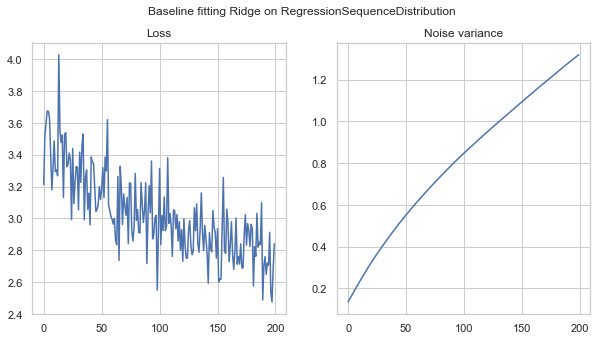

{'step': 499999,
 'config': 'L2-H4-M4-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.0013039198238402605,
 'learned_ridge_pretrain/init_delta': 0.9328494668006897,
 'learned_ridge_true/init_delta': 3.663938045501709,
 'learned_dmmse_pretrain/delta': 0.0013180312234908342,
 'learned_ridge_pretrain/delta': 0.9322290420532227,
 'learned_ridge_true/delta': 2.763976812362671,
 'learned_dmmse_pretrain/delta_delta': 1.411139965057373e-05,
 'learned_ridge_pretrain/delta_delta': -0.000620424747467041,
 'learned_ridge_true/delta_delta': -0.8999612331390381,
 'learned_dmmse_pretrain/noise_variance': 0.12332551181316376,
 'learned_ridge_pretrain/noise_variance': 0.14152385294437408,
 'learned_ridge_true/noise_variance': 1.318588376045227,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 4,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 't

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 72.28it/s]


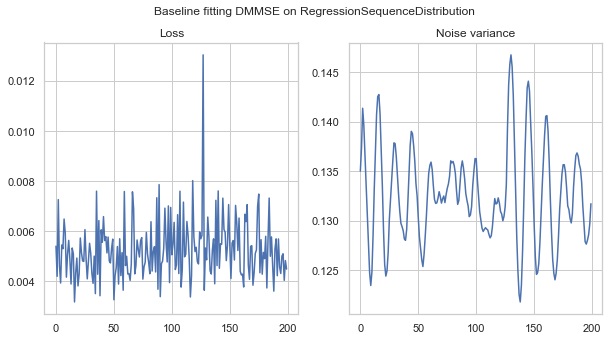

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 72.82it/s]


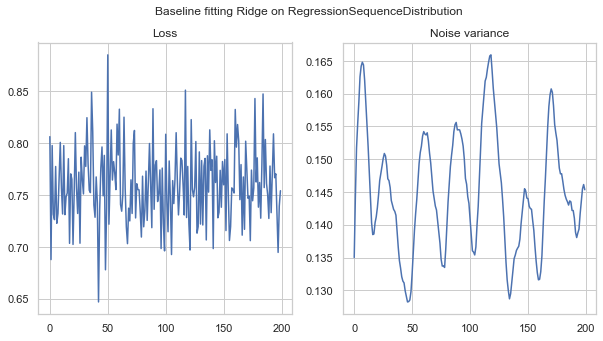

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 75.63it/s]


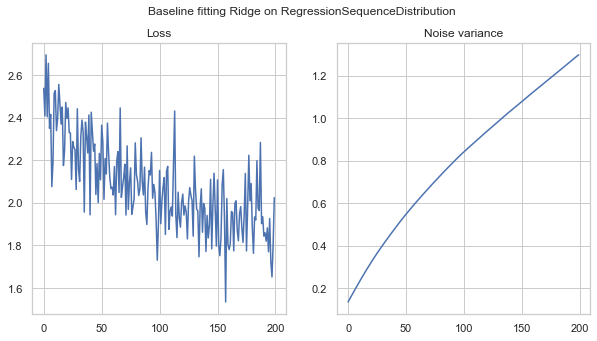

{'step': 499999,
 'config': 'L2-H4-M8-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.00515145855024457,
 'learned_ridge_pretrain/init_delta': 0.7464809417724609,
 'learned_ridge_true/init_delta': 2.74910569190979,
 'learned_dmmse_pretrain/delta': 0.005104553420096636,
 'learned_ridge_pretrain/delta': 0.7453198432922363,
 'learned_ridge_true/delta': 1.9309403896331787,
 'learned_dmmse_pretrain/delta_delta': -4.690513014793396e-05,
 'learned_ridge_pretrain/delta_delta': -0.0011610984802246094,
 'learned_ridge_true/delta_delta': -0.8181653022766113,
 'learned_dmmse_pretrain/noise_variance': 0.1317073404788971,
 'learned_ridge_pretrain/noise_variance': 0.14534412324428558,
 'learned_ridge_true/noise_variance': 1.29835844039917,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 8,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 'true

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 64.17it/s]


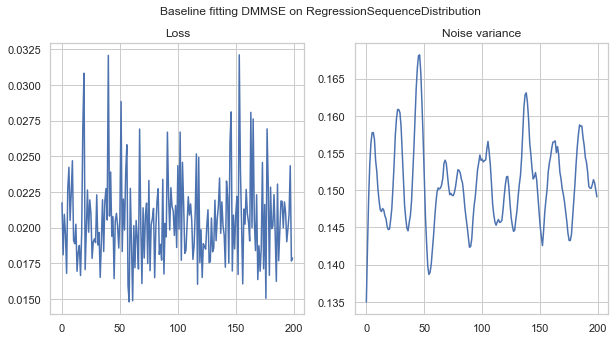

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 69.46it/s]


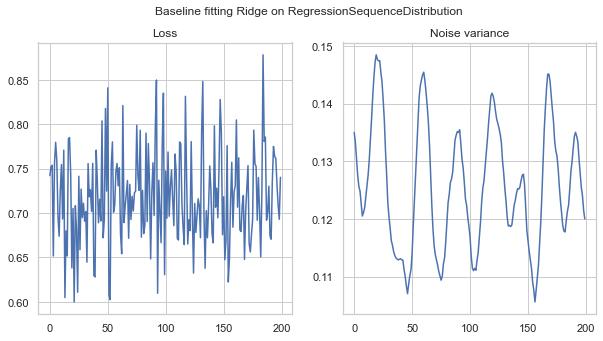

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 74.08it/s]


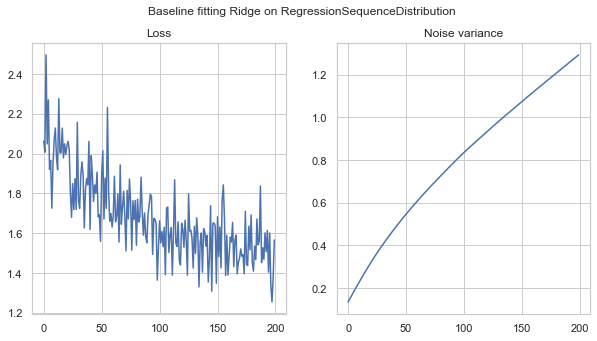

{'step': 499999,
 'config': 'L2-H4-M16-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.0209660604596138,
 'learned_ridge_pretrain/init_delta': 0.7018784284591675,
 'learned_ridge_true/init_delta': 2.299590587615967,
 'learned_dmmse_pretrain/delta': 0.020210284739732742,
 'learned_ridge_pretrain/delta': 0.702030599117279,
 'learned_ridge_true/delta': 1.534250020980835,
 'learned_dmmse_pretrain/delta_delta': -0.0007557757198810577,
 'learned_ridge_pretrain/delta_delta': 0.00015217065811157227,
 'learned_ridge_true/delta_delta': -0.7653405666351318,
 'learned_dmmse_pretrain/noise_variance': 0.14912043511867523,
 'learned_ridge_pretrain/noise_variance': 0.1199965700507164,
 'learned_ridge_true/noise_variance': 1.292431116104126,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 16,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 'tru

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 67.14it/s]


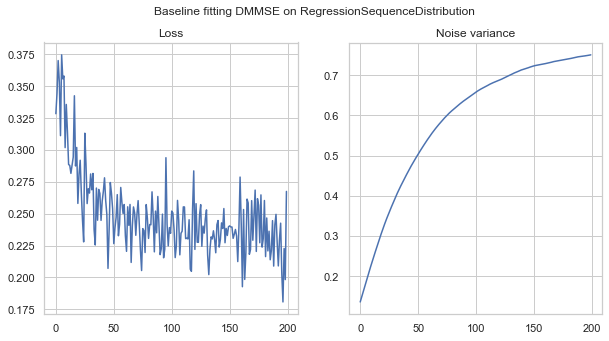

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 69.89it/s]


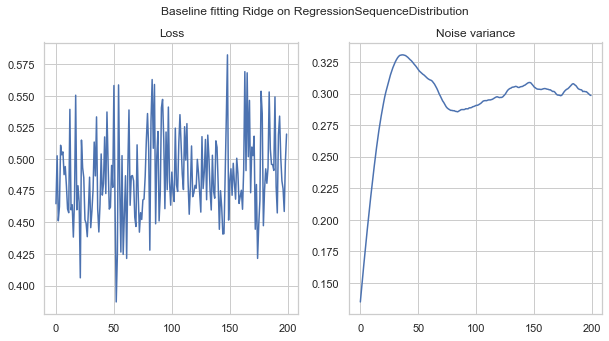

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 73.38it/s]


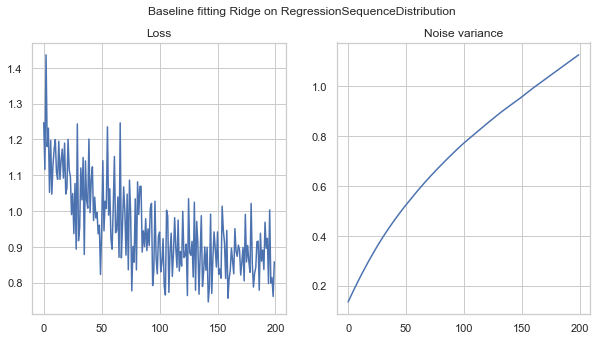

{'step': 499999,
 'config': 'L2-H4-M32-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.3937838077545166,
 'learned_ridge_pretrain/init_delta': 0.5167598724365234,
 'learned_ridge_true/init_delta': 1.373999834060669,
 'learned_dmmse_pretrain/delta': 0.2450771927833557,
 'learned_ridge_pretrain/delta': 0.4713584780693054,
 'learned_ridge_true/delta': 0.8804927468299866,
 'learned_dmmse_pretrain/delta_delta': -0.1487066149711609,
 'learned_ridge_pretrain/delta_delta': -0.04540139436721802,
 'learned_ridge_true/delta_delta': -0.4935070872306824,
 'learned_dmmse_pretrain/noise_variance': 0.7511737942695618,
 'learned_ridge_pretrain/noise_variance': 0.298444539308548,
 'learned_ridge_true/noise_variance': 1.126749873161316,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 32,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 'true_seed'

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 67.71it/s]


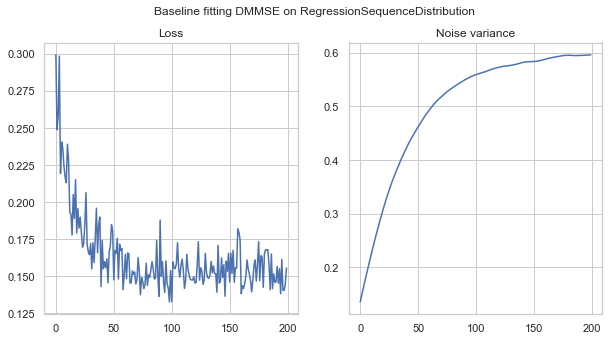

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 69.80it/s]


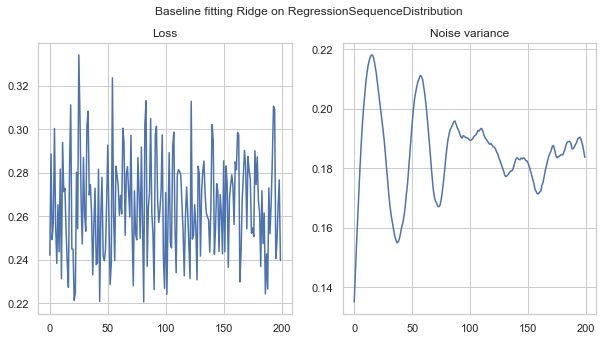

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 73.99it/s]


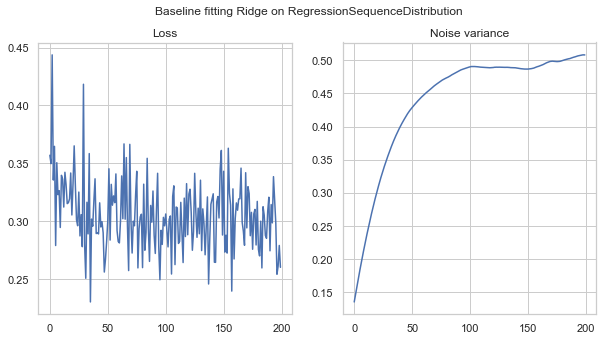

{'step': 499999,
 'config': 'L2-H4-M64-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.28706061840057373,
 'learned_ridge_pretrain/init_delta': 0.2548280954360962,
 'learned_ridge_true/init_delta': 0.42404705286026,
 'learned_dmmse_pretrain/delta': 0.14584091305732727,
 'learned_ridge_pretrain/delta': 0.24426306784152985,
 'learned_ridge_true/delta': 0.3207909166812897,
 'learned_dmmse_pretrain/delta_delta': -0.14121970534324646,
 'learned_ridge_pretrain/delta_delta': -0.010565027594566345,
 'learned_ridge_true/delta_delta': -0.10325613617897034,
 'learned_dmmse_pretrain/noise_variance': 0.5960183143615723,
 'learned_ridge_pretrain/noise_variance': 0.18365684151649475,
 'learned_ridge_true/noise_variance': 0.508194625377655,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 64,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 'tru

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 67.13it/s]


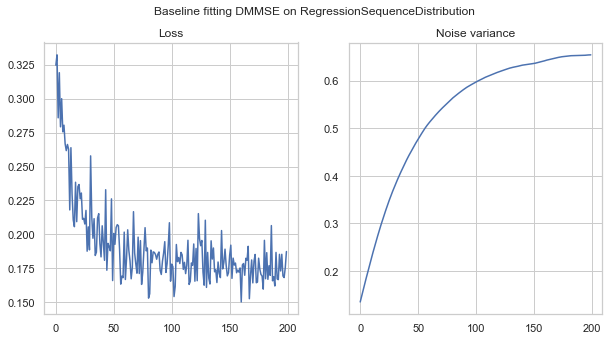

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 70.83it/s]


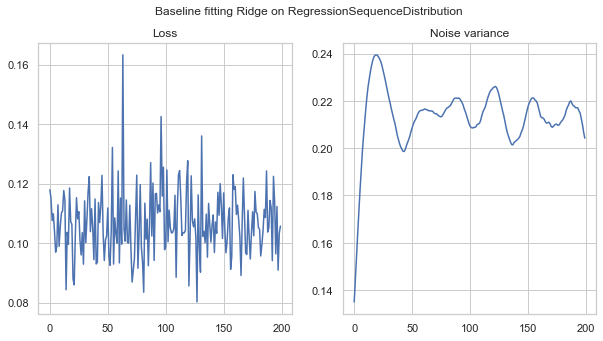

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 72.98it/s]


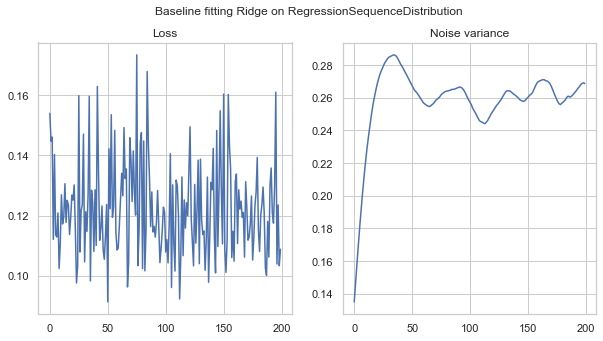

{'step': 499999,
 'config': 'L2-H4-M128-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.3339264988899231,
 'learned_ridge_pretrain/init_delta': 0.11221101135015488,
 'learned_ridge_true/init_delta': 0.1644710898399353,
 'learned_dmmse_pretrain/delta': 0.17532384395599365,
 'learned_ridge_pretrain/delta': 0.09706030786037445,
 'learned_ridge_true/delta': 0.13338598608970642,
 'learned_dmmse_pretrain/delta_delta': -0.15860265493392944,
 'learned_ridge_pretrain/delta_delta': -0.015150703489780426,
 'learned_ridge_true/delta_delta': -0.031085103750228882,
 'learned_dmmse_pretrain/noise_variance': 0.6543622612953186,
 'learned_ridge_pretrain/noise_variance': 0.20425084233283997,
 'learned_ridge_true/noise_variance': 0.2685147225856781,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 128,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 64.24it/s]


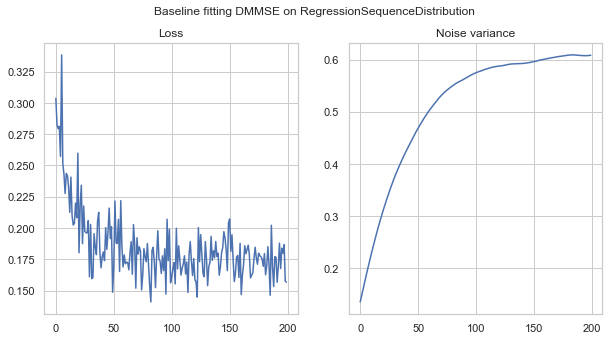

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 68.82it/s]


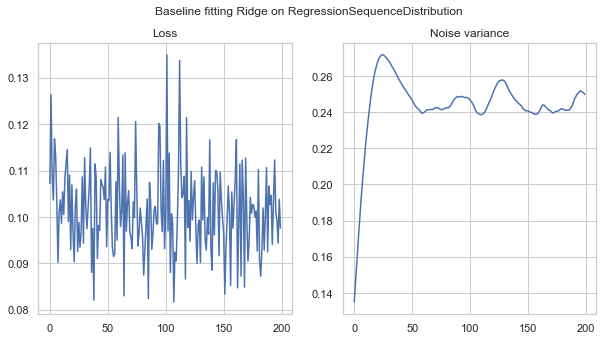

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 70.36it/s]


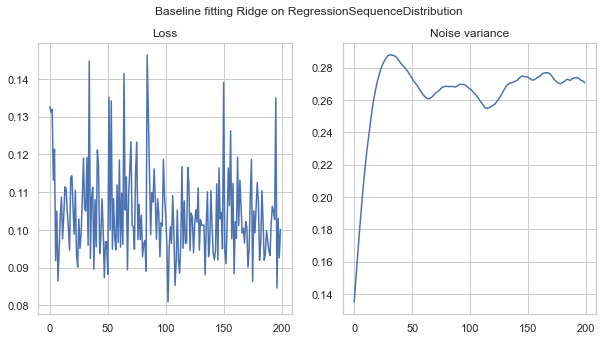

{'step': 499999,
 'config': 'L2-H4-M256-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.3434777557849884,
 'learned_ridge_pretrain/init_delta': 0.1288631707429886,
 'learned_ridge_true/init_delta': 0.14983655512332916,
 'learned_dmmse_pretrain/delta': 0.1948234736919403,
 'learned_ridge_pretrain/delta': 0.10261781513690948,
 'learned_ridge_true/delta': 0.11700057983398438,
 'learned_dmmse_pretrain/delta_delta': -0.1486542820930481,
 'learned_ridge_pretrain/delta_delta': -0.0262453556060791,
 'learned_ridge_true/delta_delta': -0.03283597528934479,
 'learned_dmmse_pretrain/noise_variance': 0.608370840549469,
 'learned_ridge_pretrain/noise_variance': 0.24969656765460968,
 'learned_ridge_true/noise_variance': 0.2706094980239868,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 256,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 'tr

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 66.89it/s]


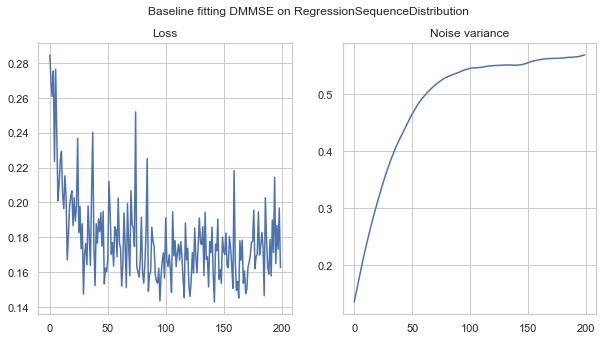

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 73.90it/s]


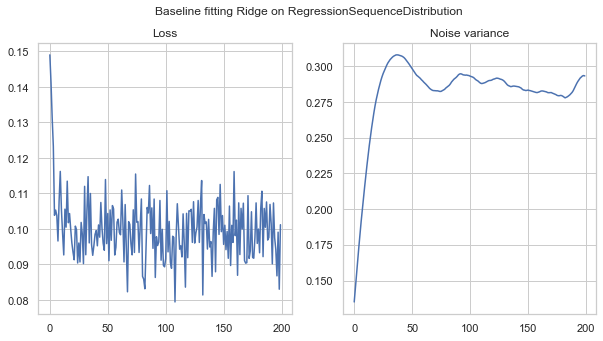

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 75.62it/s]


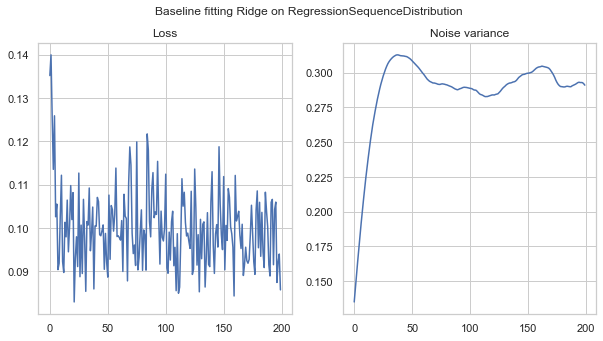

{'step': 499999,
 'config': 'L2-H4-M512-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.30432069301605225,
 'learned_ridge_pretrain/init_delta': 0.13496485352516174,
 'learned_ridge_true/init_delta': 0.1459948867559433,
 'learned_dmmse_pretrain/delta': 0.1793985664844513,
 'learned_ridge_pretrain/delta': 0.10008400678634644,
 'learned_ridge_true/delta': 0.10915769636631012,
 'learned_dmmse_pretrain/delta_delta': -0.12492212653160095,
 'learned_ridge_pretrain/delta_delta': -0.03488084673881531,
 'learned_ridge_true/delta_delta': -0.03683719038963318,
 'learned_dmmse_pretrain/noise_variance': 0.5693501830101013,
 'learned_ridge_pretrain/noise_variance': 0.2931097447872162,
 'learned_ridge_true/noise_variance': 0.2909294366836548,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 512,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 63.88it/s]


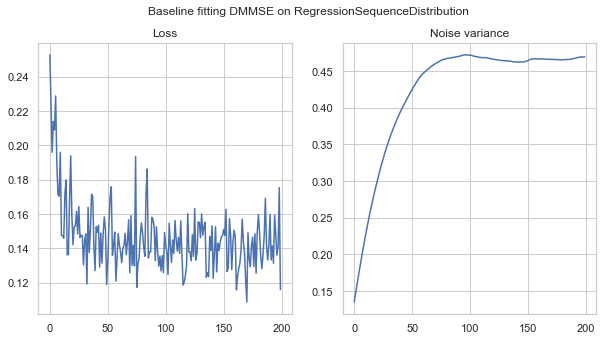

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 69.73it/s]


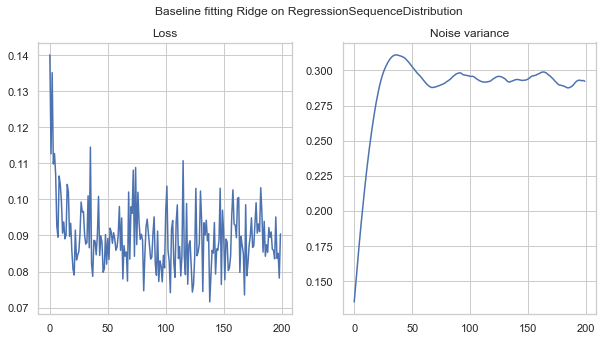

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 71.89it/s]


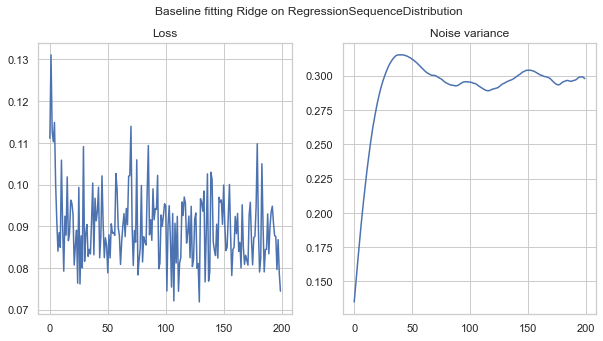

{'step': 499999,
 'config': 'L2-H4-M1024-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.2419438660144806,
 'learned_ridge_pretrain/init_delta': 0.132051482796669,
 'learned_ridge_true/init_delta': 0.13265825808048248,
 'learned_dmmse_pretrain/delta': 0.15483087301254272,
 'learned_ridge_pretrain/delta': 0.09484691917896271,
 'learned_ridge_true/delta': 0.09288626909255981,
 'learned_dmmse_pretrain/delta_delta': -0.08711299300193787,
 'learned_ridge_pretrain/delta_delta': -0.0372045636177063,
 'learned_ridge_true/delta_delta': -0.03977198898792267,
 'learned_dmmse_pretrain/noise_variance': 0.4693247079849243,
 'learned_ridge_pretrain/noise_variance': 0.2923099994659424,
 'learned_ridge_true/noise_variance': 0.2978738248348236,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 1024,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed': 1,
 

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 55.20it/s]


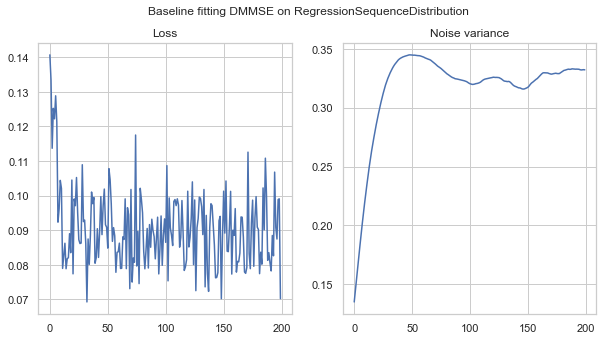

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 67.11it/s]


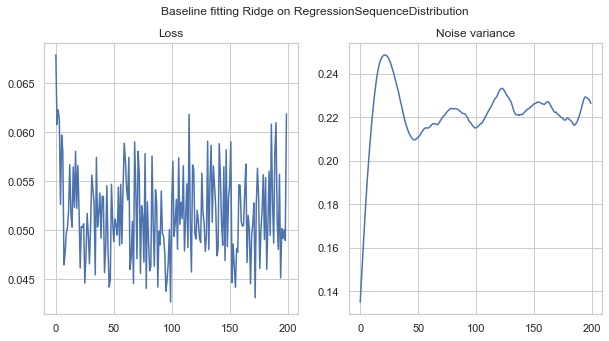

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 68.92it/s]


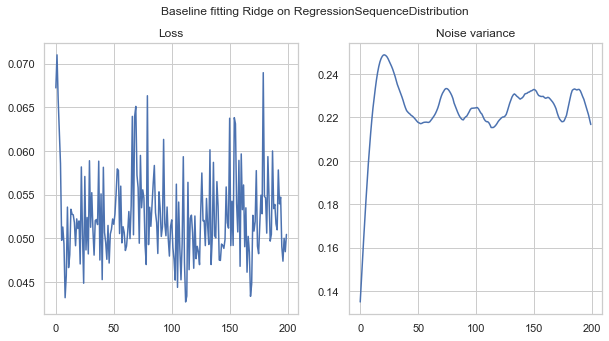

{'step': 499999,
 'config': 'L2-H4-M2048-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.15112540125846863,
 'learned_ridge_pretrain/init_delta': 0.06994971632957458,
 'learned_ridge_true/init_delta': 0.07209649682044983,
 'learned_dmmse_pretrain/delta': 0.09716001152992249,
 'learned_ridge_pretrain/delta': 0.05336207523941994,
 'learned_ridge_true/delta': 0.05437369644641876,
 'learned_dmmse_pretrain/delta_delta': -0.05396538972854614,
 'learned_ridge_pretrain/delta_delta': -0.016587641090154648,
 'learned_ridge_true/delta_delta': -0.017722800374031067,
 'learned_dmmse_pretrain/noise_variance': 0.33222511410713196,
 'learned_ridge_pretrain/noise_variance': 0.2262726128101349,
 'learned_ridge_true/noise_variance': 0.21671953797340393,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 2048,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_see

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 54.99it/s]


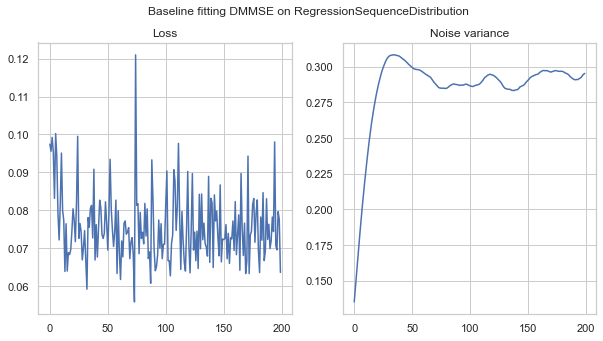

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 67.92it/s]


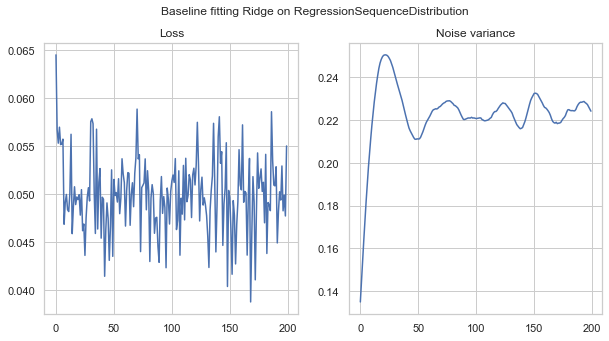

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 71.39it/s]


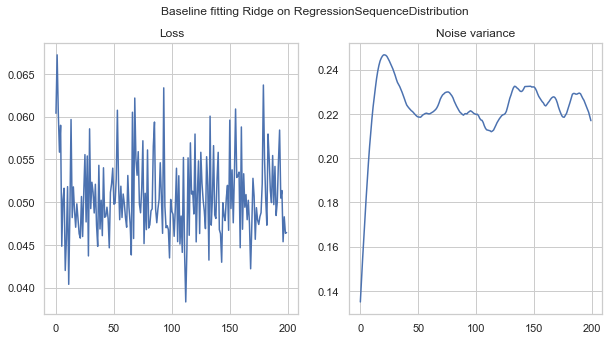

{'step': 499999,
 'config': 'L2-H4-M4096-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.10617353022098541,
 'learned_ridge_pretrain/init_delta': 0.06952092796564102,
 'learned_ridge_true/init_delta': 0.06793561577796936,
 'learned_dmmse_pretrain/delta': 0.07206715643405914,
 'learned_ridge_pretrain/delta': 0.052863359451293945,
 'learned_ridge_true/delta': 0.05005588382482529,
 'learned_dmmse_pretrain/delta_delta': -0.03410637378692627,
 'learned_ridge_pretrain/delta_delta': -0.016657568514347076,
 'learned_ridge_true/delta_delta': -0.017879731953144073,
 'learned_dmmse_pretrain/noise_variance': 0.2951701581478119,
 'learned_ridge_pretrain/noise_variance': 0.22421690821647644,
 'learned_ridge_true/noise_variance': 0.2169412523508072,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 4096,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_see

Fitting...: 100%|██████████| 200/200 [00:04<00:00, 43.10it/s]


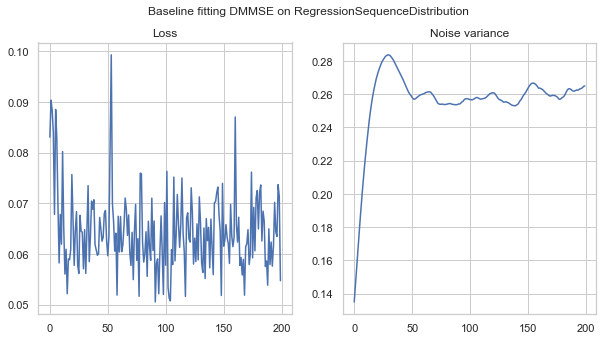

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 59.33it/s]


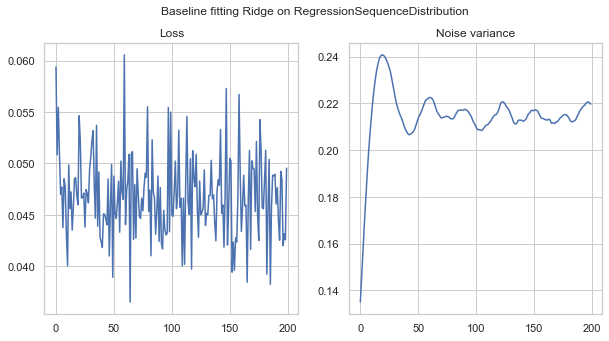

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 58.48it/s]


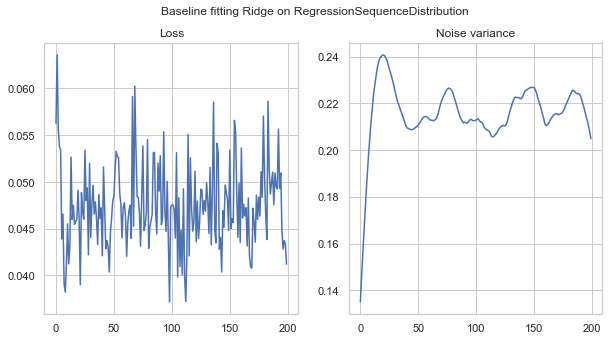

{'step': 499999,
 'config': 'L2-H4-M8192-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.08576932549476624,
 'learned_ridge_pretrain/init_delta': 0.06139783188700676,
 'learned_ridge_true/init_delta': 0.06304710358381271,
 'learned_dmmse_pretrain/delta': 0.06124888360500336,
 'learned_ridge_pretrain/delta': 0.047485608607530594,
 'learned_ridge_true/delta': 0.047634273767471313,
 'learned_dmmse_pretrain/delta_delta': -0.02452044188976288,
 'learned_ridge_pretrain/delta_delta': -0.013912223279476166,
 'learned_ridge_true/delta_delta': -0.0154128298163414,
 'learned_dmmse_pretrain/noise_variance': 0.2649790942668915,
 'learned_ridge_pretrain/noise_variance': 0.2197078913450241,
 'learned_ridge_true/noise_variance': 0.20489457249641418,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 8192,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed

Fitting...: 100%|██████████| 200/200 [00:06<00:00, 30.57it/s]


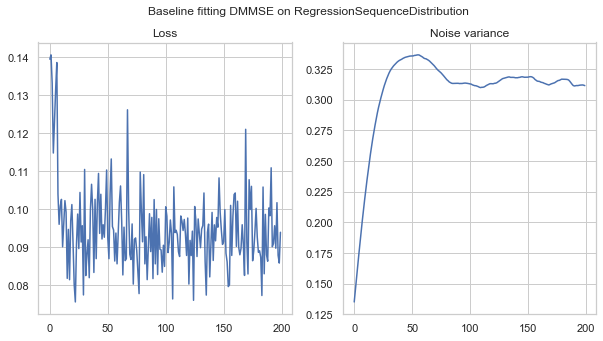

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 67.71it/s]


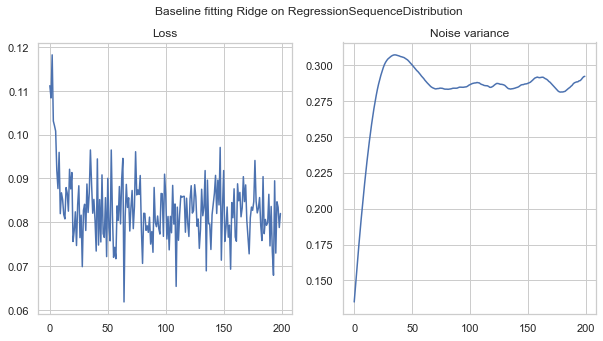

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 70.13it/s]


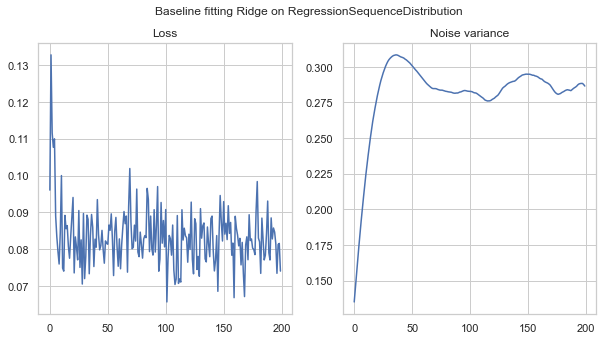

{'step': 499999,
 'config': 'L2-H4-M16384-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.12865294516086578,
 'learned_ridge_pretrain/init_delta': 0.11409689486026764,
 'learned_ridge_true/init_delta': 0.12125658988952637,
 'learned_dmmse_pretrain/delta': 0.08892352879047394,
 'learned_ridge_pretrain/delta': 0.08154058456420898,
 'learned_ridge_true/delta': 0.08605173230171204,
 'learned_dmmse_pretrain/delta_delta': -0.039729416370391846,
 'learned_ridge_pretrain/delta_delta': -0.032556310296058655,
 'learned_ridge_true/delta_delta': -0.03520485758781433,
 'learned_dmmse_pretrain/noise_variance': 0.3114072382450104,
 'learned_ridge_pretrain/noise_variance': 0.29221248626708984,
 'learned_ridge_true/noise_variance': 0.28650957345962524,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 16384,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_s

Fitting...: 100%|██████████| 200/200 [00:12<00:00, 16.61it/s]


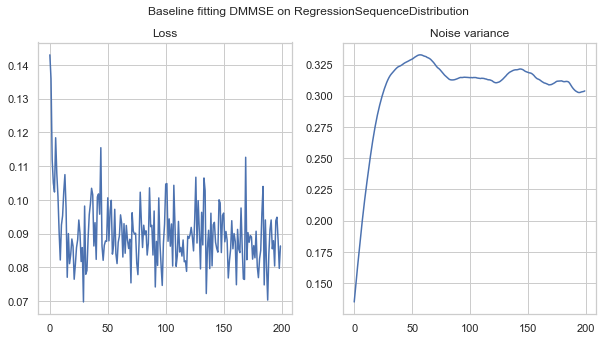

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 65.60it/s]


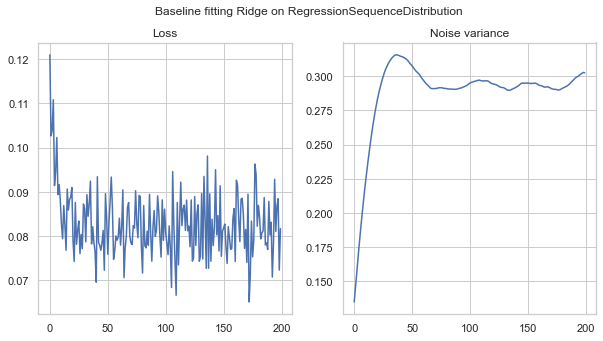

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 73.03it/s]


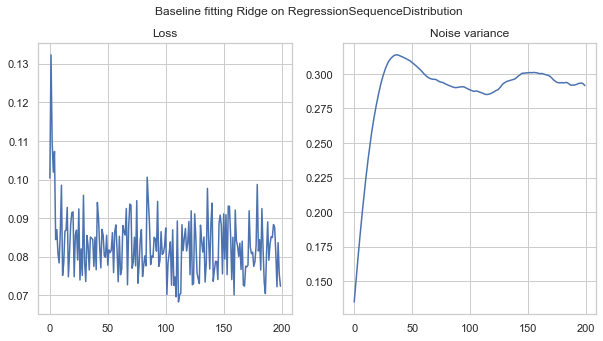

{'step': 499999,
 'config': 'L2-H4-M32768-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.13357658684253693,
 'learned_ridge_pretrain/init_delta': 0.12221844494342804,
 'learned_ridge_true/init_delta': 0.12595871090888977,
 'learned_dmmse_pretrain/delta': 0.08962103724479675,
 'learned_ridge_pretrain/delta': 0.08397231996059418,
 'learned_ridge_true/delta': 0.08719487488269806,
 'learned_dmmse_pretrain/delta_delta': -0.04395554959774017,
 'learned_ridge_pretrain/delta_delta': -0.03824612498283386,
 'learned_ridge_true/delta_delta': -0.03876383602619171,
 'learned_dmmse_pretrain/noise_variance': 0.3038600981235504,
 'learned_ridge_pretrain/noise_variance': 0.3024738132953644,
 'learned_ridge_true/noise_variance': 0.29153600335121155,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 32768,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_seed

Fitting...: 100%|██████████| 200/200 [00:24<00:00,  8.17it/s]


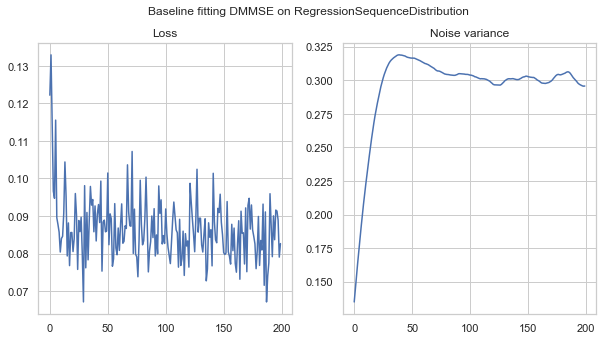

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 66.12it/s]


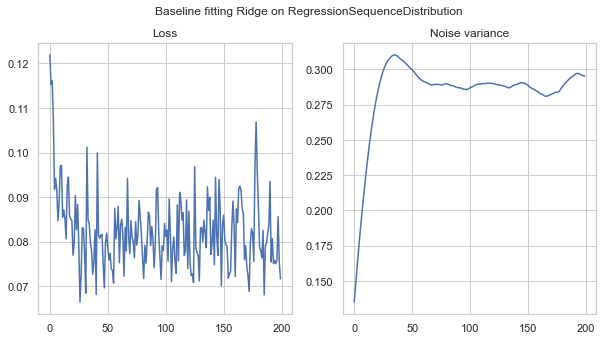

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 75.53it/s]


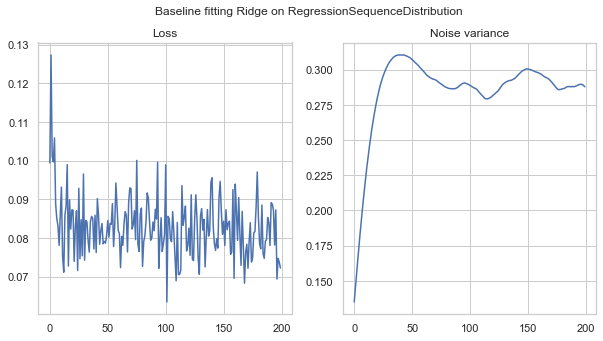

{'step': 499999,
 'config': 'L2-H4-M65536-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.13398894667625427,
 'learned_ridge_pretrain/init_delta': 0.12681186199188232,
 'learned_ridge_true/init_delta': 0.12293710559606552,
 'learned_dmmse_pretrain/delta': 0.09175537526607513,
 'learned_ridge_pretrain/delta': 0.08756941556930542,
 'learned_ridge_true/delta': 0.08552763611078262,
 'learned_dmmse_pretrain/delta_delta': -0.04223357141017914,
 'learned_ridge_pretrain/delta_delta': -0.039242446422576904,
 'learned_ridge_true/delta_delta': -0.0374094694852829,
 'learned_dmmse_pretrain/noise_variance': 0.29568716883659363,
 'learned_ridge_pretrain/noise_variance': 0.2951287627220154,
 'learned_ridge_true/noise_variance': 0.28787800669670105,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 65536,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_see

Fitting...: 100%|██████████| 200/200 [00:49<00:00,  4.08it/s]


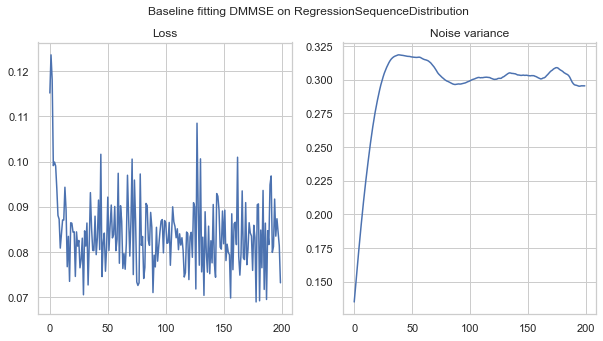

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 55.24it/s]


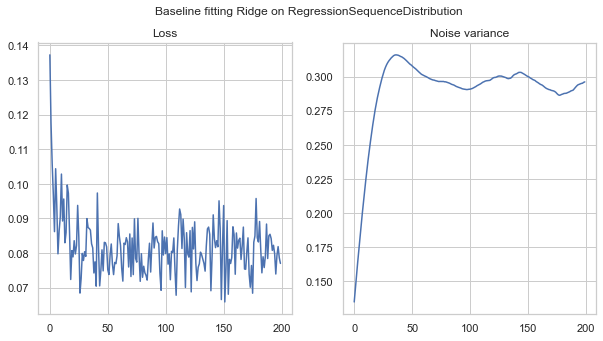

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 63.63it/s]


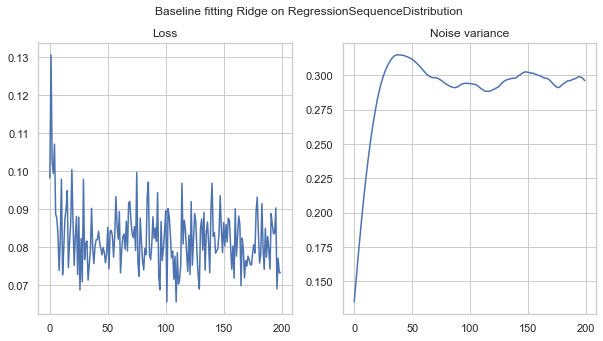

{'step': 499999,
 'config': 'L2-H4-M131072-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.12315072119235992,
 'learned_ridge_pretrain/init_delta': 0.1202157735824585,
 'learned_ridge_true/init_delta': 0.12250834703445435,
 'learned_dmmse_pretrain/delta': 0.08262968808412552,
 'learned_ridge_pretrain/delta': 0.08187932521104813,
 'learned_ridge_true/delta': 0.0848965048789978,
 'learned_dmmse_pretrain/delta_delta': -0.040521033108234406,
 'learned_ridge_pretrain/delta_delta': -0.03833644837141037,
 'learned_ridge_true/delta_delta': -0.03761184215545654,
 'learned_dmmse_pretrain/noise_variance': 0.29534822702407837,
 'learned_ridge_pretrain/noise_variance': 0.2961415946483612,
 'learned_ridge_true/noise_variance': 0.2961355447769165,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 131072,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_see

Fitting...: 100%|██████████| 200/200 [01:43<00:00,  1.94it/s]


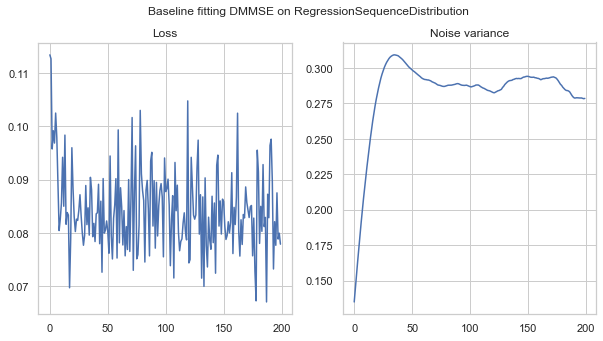

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 65.54it/s]


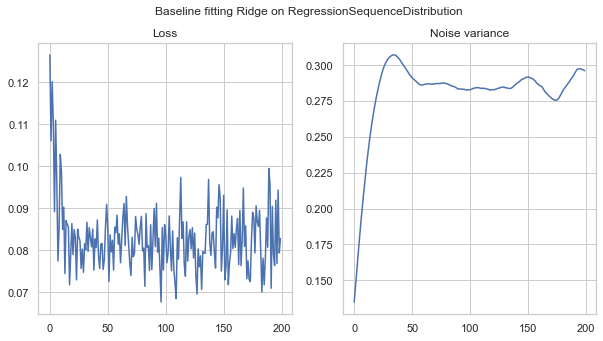

Fitting...: 100%|██████████| 200/200 [00:02<00:00, 70.45it/s]


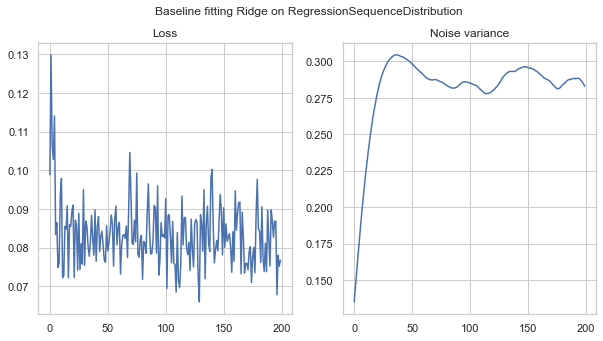

{'step': 499999,
 'config': 'L2-H4-M262144-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000',
 'learned_dmmse_pretrain/init_delta': 0.12167736887931824,
 'learned_ridge_pretrain/init_delta': 0.12035015970468521,
 'learned_ridge_true/init_delta': 0.11990281939506531,
 'learned_dmmse_pretrain/delta': 0.0855996310710907,
 'learned_ridge_pretrain/delta': 0.08475761860609055,
 'learned_ridge_true/delta': 0.08578084409236908,
 'learned_dmmse_pretrain/delta_delta': -0.03607773780822754,
 'learned_ridge_pretrain/delta_delta': -0.035592541098594666,
 'learned_ridge_true/delta_delta': -0.03412197530269623,
 'learned_dmmse_pretrain/noise_variance': 0.2785024344921112,
 'learned_ridge_pretrain/noise_variance': 0.29587745666503906,
 'learned_ridge_true/noise_variance': 0.2829578220844269,
 'task_size': 4,
 'max_examples': 8,
 'num_tasks': 262144,
 'noise_variance': 0.125,
 'embed_size': 64,
 'mlp_size': 64,
 'num_heads': 4,
 'num_layers': 2,
 'model_seed': 0,
 'pretrain_se

Fitting...: 100%|██████████| 200/200 [05:25<00:00,  1.63s/it]


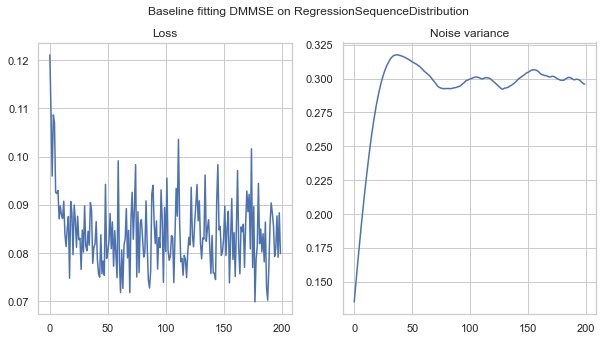

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 60.92it/s]


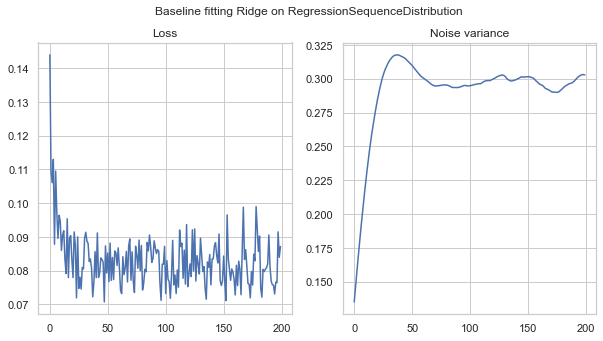

Fitting...: 100%|██████████| 200/200 [00:03<00:00, 63.81it/s]


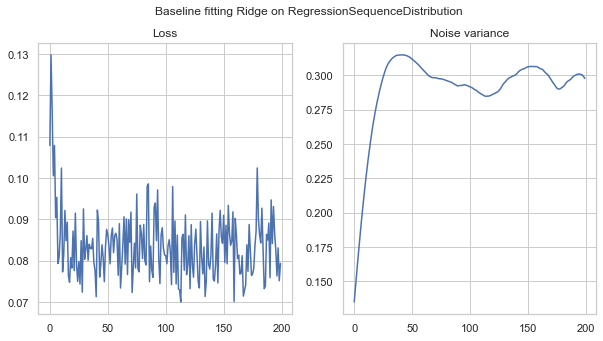

RuntimeError: MPS backend out of memory (MPS allocated: 60.99 GB, other allocations: 20.38 GB, max allowed: 81.60 GB). Tried to allocate 256.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [39]:
from devinfra.utils.iterables import flatten_dict
from icl.train import Run
import random

fit_baseline_results = []

lr = 0.01
num_steps = 2_00
LEARN_PRIOR = False

for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    run.model.load_state_dict(checkpointer[-1]["model"])

    print("Evaluating", run.config.to_slug())

    batch_size = run.config.batch_size
    num_examples = run.config.task_config.max_examples
    
    noise = run.config.task_config.noise_variance

    learned_dmmse_pretrain = DMMSE(run.pretrain_dist, noise_variance=noise, learn_prior=LEARN_PRIOR)
    learned_ridge_pretrain = Ridge(noise_variance=noise)
    learned_ridge_true = Ridge(noise_variance=noise)

    init_learned_dmmse_pretrain_delta = eval_delta_predictor(learned_dmmse_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    init_learned_ridge_pretrain_delta = eval_delta_predictor(learned_ridge_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    init_learned_ridge_true_delta = eval_delta_predictor(learned_ridge_true, run.model, run.evaluator.true_xs, run.evaluator.true_ys, device=DEVICE)
    
    fit_baseline_predictor(learned_dmmse_pretrain, run.model, run.pretrain_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)
    fit_baseline_predictor(learned_ridge_pretrain, run.model, run.pretrain_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)
    fit_baseline_predictor(learned_ridge_true, run.model, run.true_dist, num_steps=num_steps, lr=lr, device=DEVICE, batch_size=batch_size, num_examples=num_examples)

    learned_dmmse_pretrain_delta = eval_delta_predictor(learned_dmmse_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    learned_ridge_pretrain_delta = eval_delta_predictor(learned_ridge_pretrain, run.model, run.evaluator.pretrain_xs, run.evaluator.pretrain_ys, device=DEVICE)
    learned_ridge_true_delta = eval_delta_predictor(learned_ridge_true, run.model, run.evaluator.true_xs, run.evaluator.true_ys, device=DEVICE)

    fit_baseline_results.append({
        "step": checkpointer.file_ids[-1],
        "config": run.config.to_slug(),
        "learned_dmmse_pretrain/init_delta": init_learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/init_delta": init_learned_ridge_pretrain_delta.item(),
        "learned_ridge_true/init_delta": init_learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/delta": learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/delta": learned_ridge_pretrain_delta.item(),
        "learned_ridge_true/delta": learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/delta_delta": learned_dmmse_pretrain_delta.item() - init_learned_dmmse_pretrain_delta.item(),
        "learned_ridge_pretrain/delta_delta": learned_ridge_pretrain_delta.item() - init_learned_ridge_pretrain_delta.item(),        
        "learned_ridge_true/delta_delta": learned_ridge_true_delta.item() - init_learned_ridge_true_delta.item(),
        "learned_dmmse_pretrain/noise_variance": learned_dmmse_pretrain.noise_variance.item(),
        "learned_ridge_pretrain/noise_variance": learned_ridge_pretrain.noise_variance.item(),
        "learned_ridge_true/noise_variance": learned_ridge_true.noise_variance.item(),
        **flatten_dict(run.config.task_config.model_dump(), flatten_lists=True)
    })

    pp(fit_baseline_results[-1])



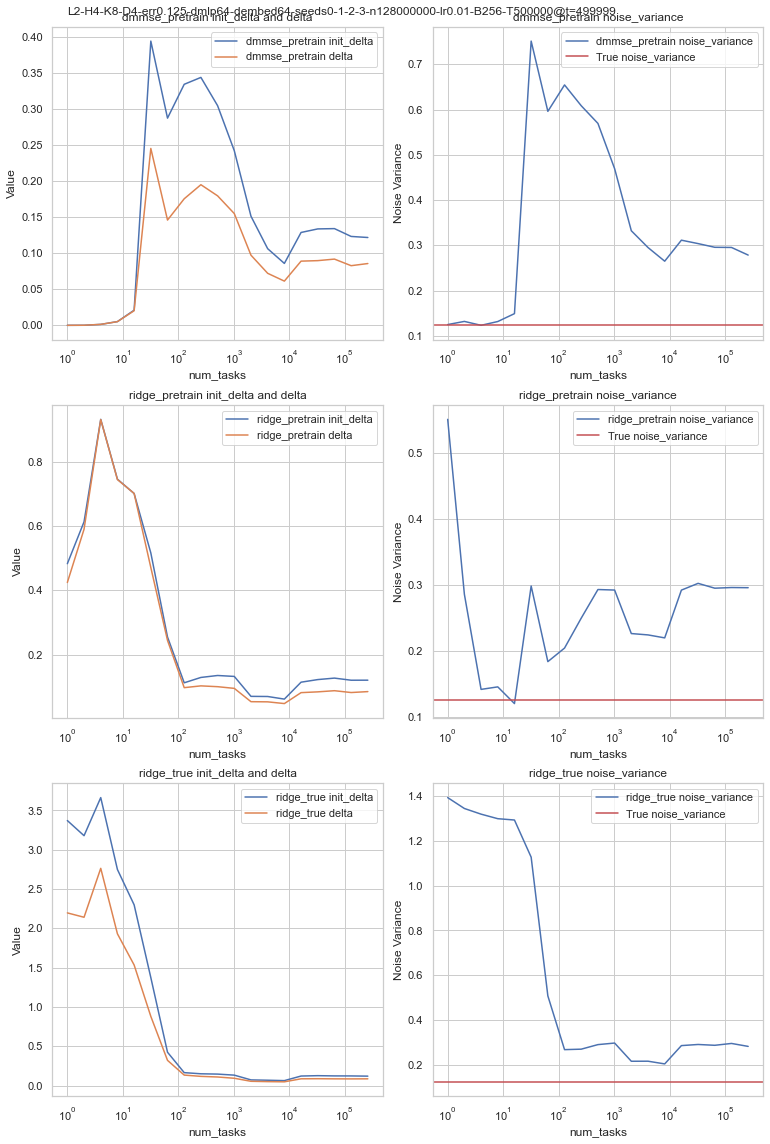

In [43]:
baseline_fits_df = pd.DataFrame(fit_baseline_results)

# Create 2x3 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

plt.suptitle(
    "L2-H4-K8-D4-err0.125-dmlp64-dembed64-seeds0-1-2-3-n128000000-lr0.01-B256-T500000@t=499999"
)

# Define the labels for rows
row_labels = ['dmmse_pretrain', 'ridge_pretrain', 'ridge_true']

# Loop through the rows
for i, row_label in enumerate(row_labels):
    
    # First column: init_delta and delta
    ax1 = axes[i, 0]
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/init_delta', ax=ax1, label=f'{row_label} init_delta')
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/delta', ax=ax1, label=f'{row_label} delta')
    ax1.set_title(f"{row_label} init_delta and delta")
    ax1.set_xlabel('num_tasks')
    ax1.set_ylabel('Value')
    
    # Second column: noise_variance
    ax2 = axes[i, 1]
    baseline_fits_df.plot(x='num_tasks', y=f'learned_{row_label}/noise_variance', ax=ax2, label=f'{row_label} noise_variance')
    ax2.axhline(y=0.125, color='r', linestyle='-', label='True noise_variance')

    ax2.legend()

    ax2.set_title(f"{row_label} noise_variance")
    ax2.set_xlabel('num_tasks')
    ax2.set_ylabel('Noise Variance')

for ax in axes.flat:
    ax.set_xscale("log")

plt.tight_layout(rect=[0.1, 0.1, 1, 1])
plt.show()


## PCA

In [7]:
def iter_enumerated_models(model, checkpointer, verbose=False):
    for file_id in tqdm(checkpointer.file_ids, desc="Iterating over checkpoints", disable=not verbose):
        model.load_state_dict(checkpointer.load_file(file_id)["model"])
        yield file_id, model

def iter_models(model, checkpointer, verbose=False):
    for file_id in tqdm(checkpointer.file_ids, desc="Iterating over checkpoints", disable=not verbose):
        model.load_state_dict(checkpointer.load_file(file_id)["model"])
        yield model

In [8]:
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        hooked_model = hook(model, *paths)
        return {k: convert_tensor(v, return_type) for k, v in hooked_model.run_with_cache(xs, ys)[1].items() if k in paths and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }


def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results

In [ ]:
# demo = Run(configs[2])
# demo_models = iter_models(demo.model, demo.checkpointer, verbose=True)

# demo_logits_pca_3, demo_logits_reduced_3  = get_pca_activations_trace(
#     demo_models, 
#     demo.evaluator.pretrain_xs, 
#     demo.evaluator.pretrain_ys, 
#     "token_sequence_transformer",
#     num_components=3
# )['token_sequence_transformer']

# steps = demo.checkpointer.file_ids

In [9]:
from typing import Optional

def plot_sample_evolution(steps, samples, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Main plot
    sc = ax.scatter(samples[:, 0], samples[:, 1], c=steps, cmap='viridis', s=50, alpha=0.6)

    if connect_dots:
        ax.plot(samples[:, 0], samples[:, 1], c='black', alpha=0.2)

    plt.colorbar(sc, ax=ax, label='Steps')
    
    # Label some points
    total_samples = len(samples)
    step = total_samples // num_points_to_label
    for i in range(0, total_samples, step):
        sample_step = steps[i]
        ax.text(samples[i, 0], samples[i, 1], str(sample_step), fontsize=12, ha='right', va='bottom')
        
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)


def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

    for i, ratio in enumerate(pca.explained_variance_ratio_):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Component')
    ax.set_ylabel('Variance')


def plot_sample_evolution_with_inset(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    plot_sample_evolution(steps, samples, title=title, num_points_to_label=num_points_to_label, ax=ax, connect_dots=connect_dots)

    axins = ax.inset_axes([0.7, 0.05, 0.25, 0.25])  # x, y, width, height
    axins.patch.set_alpha(0.5)
    plot_explained_variance(pca, ax=axins)
    
    # Inset for explained variance at the bottom right corner with slight transparency
    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

    
def plot_multiple_slices(steps, samples, pca, title="Sample Evolution in 2D Plane", num_points_to_label=10, save: Optional[str] = None, ax: Optional = None, connect_dots=False):
    num_pca_components = samples.shape[-1]
    num_rows = num_pca_components - 1
    fig, ax = plt.subplots(num_rows, num_rows, figsize=(20, 20))

    fig.suptitle(title)

    for i in range(num_pca_components):
        for j in range(i):
            sc = ax[i-1, j].scatter(samples[:, i], samples[:, j], c=steps, cmap='viridis', s=50, alpha=0.6)
            ax[i-1, j].set_xlabel(f'Feature {i}')
            ax[i-1, j].set_ylabel(f'Feature {j}')
            ax[i-1, j].set_title(f'Feature {i} vs Feature {j}')

            if connect_dots:
                ax[i-1, j].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # Label some points
            total_samples = len(samples)
            step = total_samples // num_points_to_label
            for k in range(0, total_samples, step):
                sample_step = steps[k]
                ax[i-1, j].text(samples[k, i], samples[k, j], str(sample_step), fontsize=12, ha='right', va='bottom')

        for j in range(i + 1, num_rows):
            ax[i, j].axis('off')


    ax[0, -1].axis('on')
    plot_explained_variance(pca, ax=ax[0, -1])

    plt.colorbar(sc, ax=ax[0, -1], label='Steps')
    plt.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)

        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)

        plt.savefig(save)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)

In [ ]:
for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    _steps = checkpointer.file_ids

    _pca, _logits_reduced = get_pca_activations_trace(
        iter_models(run.model, run.checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        "token_sequence_transformer",
        num_components=3
    )['token_sequence_transformer']
    
    plot_multiple_slices(
        _steps, 
        _logits_reduced, 
        _pca, 
        connect_dots=True, 
        title=config.to_latex(), 
        save=FIGURES / ("pca3-logits-" + config.to_slug(delimiter="-") + ".png")
    )

## Attention Entropies

In [10]:
from typing import List, Union
from torchtyping import TensorType
from devinfra.utils.iterables import map_nested

def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)

In [11]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title="", save: Optional[str] = None, normalized=False, figsize=(20, 25), logx=False, logy=False):
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title)

    num_cols = num_blocks * 2
    num_rows = 1 + 1 + num_heads

    suffix = "" if not normalized else "_normalized"
    suffix_title = "" if not normalized else " (Normalized)"

    # Create subplot for mean entropy of first two blocks
    ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    block_cmap = sns.color_palette("viridis", num_blocks)

    for b in range(num_blocks):
        ax0.plot(df.step, df[f"block_{b}/mean{suffix}"], label=f"block_{b}", color=block_cmap[b])

    ax0.set_title("Blocks")
    ax0.set_xlabel("Step")
    ax0.set_ylabel(f"Entropy{suffix_title}")
    ax0.legend()

    # Create subplots for each block, showing entropy in different heads
    ax1 = [plt.subplot2grid((num_rows, num_cols), (1, i*2), colspan=2) for i in range(num_blocks)]
    head_cmap = sns.color_palette("viridis", num_heads)
    
    for b in range(num_blocks):
        ax1[b].set_title(f"Block {b}")
        ax1[b].set_xlabel("Step")
        ax1[b].set_ylabel(f"Entropy{suffix_title}")
        for h in range(num_heads):
            series = df[f"block_{b}/head_{h}/mean{suffix}"]
            ax1[b].plot(df.step, series, label=f"Head {h}", color=head_cmap[h])

    ax1[0].legend()

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + 2, i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0
    token_cmap = sns.color_palette("viridis", num_tokens)


    for h in range(num_heads):
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax2[ax_idx].set_title(f"Block {b} Head {h}")
                ax2[ax_idx].set_xlabel("Step")
                ax2[ax_idx].set_ylabel(f"Entropy{suffix_title}")

                for t in range(1-int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}{suffix}"]
                    ax2[ax_idx].plot(df.step, series, label=f"Token {t}", color=token_cmap[t])
                    
                ax_idx += 1

    ax2[0].legend()
    ax2[1].legend()

    for ax in [ax0, *ax1, *ax2]:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


In [ ]:
demo = Run(configs[2])

num_blocks = demo.config.task_config.num_layers
num_heads = demo.config.task_config.num_heads
num_tokens = demo.config.task_config.max_examples

df = get_attention_entropies_trace(
    demo.checkpointer.file_ids,
    iter_models(demo.model, demo.checkpointer, verbose=True), 
    demo.evaluator.pretrain_xs, 
    demo.evaluator.pretrain_ys, 
    **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
)

demo_attn_entropy_slug = "attn-S-" + demo.config.to_slug(delimiter="-")

for normalized in (True, False):
    plot_attention_patterns(
        df, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=demo.config.to_latex(), 
        save=FIGURES / (demo_attn_entropy_slug + ".png"),
        figsize=(25, 25),
        normalized=normalized
    )

# df.to_csv(ANALYSIS / (demo_attn_entropy_slug + ".csv"))

In [ ]:
for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    
    num_blocks = run.config.task_config.num_layers
    num_heads = run.config.task_config.num_heads
    num_tokens = run.config.task_config.max_examples

    df = get_attention_entropies_trace(
        checkpointer.file_ids,
        iter_models(run.model, checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
    )
    
    slug = "attn-S-" + run.config.to_slug(delimiter="-")

    plot_attention_patterns(
        df, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=run.config.to_latex(), 
        save=FIGURES / (slug + ".png"),
        figsize=(25, 25),
        normalized=True
    )

    df.to_csv(ANALYSIS / (slug + ".csv"))

os.system('say "Your program has finished."')

## RLCTs & Covariance 

In [12]:
from icl.train import Run
demo = Run(configs[2])
attn_weights = demo.model.token_sequence_transformer.blocks[0].attention.attention.weight
attn_weights.shape


torch.Size([192, 64])

In [13]:
numel_per_layer = attn_weights.numel()

def num_params_to_gb(num: int):
    return f"{num * (32 / 8) / (10 ** 9):.2f} Gb"

for num_blocks in [2, 4, 8]:
    for num_heads in [2, 4]:
        numel_per_head = numel_per_layer // num_heads

        within_head_cov_size = (numel_per_head ** 2)  * num_heads * num_blocks
        between_head_cov_size = (numel_per_head ** 2) * num_heads * num_heads * (num_blocks-1)

        full_cov_size = (numel_per_layer * num_blocks) ** 2

        reduction = full_cov_size - within_head_cov_size - between_head_cov_size

        print(f"\nL{num_blocks}H{num_heads}")
        print("Full:", f"{full_cov_size:,} ({num_params_to_gb(full_cov_size)})")
        print("Within heads:", f"{within_head_cov_size:,} ({num_params_to_gb(within_head_cov_size)})")
        print("Between heads:", f"{between_head_cov_size:,} ({num_params_to_gb(between_head_cov_size)})")
        print("Reduction:", f"-{reduction:,} (-{reduction/full_cov_size * 100:.2f}%)")

# attn_weights.numel(), f"{(32 // 8 * (attn_weights.numel() * 2 ) ** 2):,}", attn_weights.dtype


L2H2
Full: 603,979,776 (2.42 Gb)
Within heads: 150,994,944 (0.60 Gb)
Between heads: 150,994,944 (0.60 Gb)
Reduction: -301,989,888 (-50.00%)

L2H4
Full: 603,979,776 (2.42 Gb)
Within heads: 75,497,472 (0.30 Gb)
Between heads: 150,994,944 (0.60 Gb)
Reduction: -377,487,360 (-62.50%)

L4H2
Full: 2,415,919,104 (9.66 Gb)
Within heads: 301,989,888 (1.21 Gb)
Between heads: 452,984,832 (1.81 Gb)
Reduction: -1,660,944,384 (-68.75%)

L4H4
Full: 2,415,919,104 (9.66 Gb)
Within heads: 150,994,944 (0.60 Gb)
Between heads: 452,984,832 (1.81 Gb)
Reduction: -1,811,939,328 (-75.00%)

L8H2
Full: 9,663,676,416 (38.65 Gb)
Within heads: 603,979,776 (2.42 Gb)
Between heads: 1,056,964,608 (4.23 Gb)
Reduction: -8,002,732,032 (-82.81%)

L8H4
Full: 9,663,676,416 (38.65 Gb)
Within heads: 301,989,888 (1.21 Gb)
Between heads: 1,056,964,608 (4.23 Gb)
Reduction: -8,304,721,920 (-85.94%)


In [14]:
def split_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int):
    W_split = W.view((embed_dim, num_heads, head_size * 3))
    
    for h in range(num_heads):
        yield tuple(W_split[:, h, i*head_size:(i+1)*head_size] for i in range(3))


def plot_attn_weights(W: torch.Tensor, num_heads: int, embed_dim: int, head_size: int, subtitles=("$W_Q^{(h)}$", "$W_K^{(h)}$", "$W_V^{(h)}$"), title="", save: Optional[str] = None):
    heads = list(split_attn_weights(W, num_heads, embed_dim, head_size))

    fig, axs = plt.subplots(num_heads, 3, figsize=(25, 10))
    plt.suptitle(title)

    for h, head in enumerate(heads):
        axs[h, 0].set_ylabel(f"Head {h}\nHead Size")

        for i, mat in enumerate(head):
            axs[h, i].matshow(mat.detach().cpu().numpy().T, cmap='viridis') 

    for i, subtitle in enumerate(subtitles):
        axs[0, i].set_title(subtitle)
        axs[-1, i].set_xlabel("Embedding Dimension")

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()


def plot_attn_head_weights(head: torch.Tensor, embed_dim, head_size: int, title="", subtitles=("$W_Q$", "$W_K$", "$W_V$"), save: Optional[str] = None):
    head_Ex3c = head.view((embed_dim, head_size * 3))
    q, k, v = tuple(head_Ex3c[:, i*head_size:(i+1)*head_size].detach().cpu().numpy() for i in range(3))

    fig, ax = plt.subplots(1, 3, figsize=(30, 3.5))
    plt.suptitle(title)

    for i, (mat, subtitle) in enumerate(zip((q, k, v), subtitles)):
        ax[i].set_title(subtitle)
        ax[i].matshow(mat.T, cmap='viridis')
        ax[i].set_xlabel("Embedding Dimension")
        ax[i].set_ylabel("Head Size")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()

In [15]:
def plot_attn_eigencomponents(evecs, evals, slug: Optional[str] = None):
    for i in range(1, 1 + len(evals)):
        attn0, attn1 = evecs[:evecs.shape[0]//2, -i], evecs[evecs.shape[0]//2:, -i]

        for layer, attn in enumerate((attn0, attn1)):
            plot_attn_weights(
                torch.Tensor(attn), 
                num_heads=4,
                embed_dim=64, 
                head_size=16, 
                title=f"Eigenvector {i-1} of covariance matrix within attention layer 0 ($\lambda_{i-1}={evals[-i]}$)",
                subtitles=(f"$u_{{Q,{i-1}}}^{{({layer})}}$", f"$u_{{K,{i-1}}}^{{({layer})}}$", f"$u_{{V,{i-1}}}^{{({layer})}}$"),
                save=(FIGURES / (f"cov-attn{layer}-evec{i-1}-" + slug + ".png") if slug else None)
            )

In [16]:
plot_attn_weights(attn0, 4, 64, 16, title="Attention layer 0")

num_heads = 4
attn0_view = attn0.view((64, num_heads, 16 * 3))
heads = [attn0_view[:, h, :] for h in range(num_heads)]
full_head_size = 16 * 3 * 64
pseudo_cov = heads[0].reshape((full_head_size, 1)) * heads[1].reshape((1, full_head_size)) 
head_evals, head_evecs = eigsh(pseudo_cov.detach().cpu().numpy(), k=3, which="LM")
del pseudo_cov


print(head_evals)
plot_attn_head_weights(
    torch.Tensor(head_evecs[:, -1]), 
    64, 
    16, 
    title="Principal eigenvalue of covariance matrix within head 1",
    subtitles=("$u_{Q,1}^{(1)}$", "$u_{K,1}^{(1)}$", "$u_{V,1}^{(1)}$")   
)


NameError: name 'attn0' is not defined

In [17]:
from icl.analysis.rlct import make_slt_evals

def generate_slt_observables(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **kwargs
):
    trainset = torch.utils.data.TensorDataset(xs, ys)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(xs))
    slt_evals = make_slt_evals(
        dataset=trainset,
        loader=trainloader,
        **kwargs
    )

    for step, model in zip(steps, models):
        yield step, slt_evals(model)

FileNotFoundError: [Errno 2] No such file or directory: '../../sweeps/small-sweep-2.yaml'

In [19]:
print(checkpointer.file_ids)

[0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124, 162, 211, 276, 362, 473, 618, 808, 1056, 1381, 1805, 2359, 3084, 4031, 5269, 6887, 9003, 10204, 11767, 15381, 20104, 20408, 26279, 30612, 34349, 40816, 44897, 51020, 58684, 61224, 71428, 76706, 81632, 91836, 100262, 102040, 112244, 122448, 131051, 132653, 142857, 153061, 163265, 171296, 173469, 183673, 193877, 204081, 214285, 223899, 224489, 234693, 244897, 255102, 265306, 275510, 285714, 292657, 295918, 306122, 316326, 326530, 336734, 346938, 357142, 367346, 377551, 382529, 387755, 397959, 408163, 418367, 428571, 438775, 448979, 459183, 469387, 479591, 489795, 499999]


In [131]:
def plot_learning_coeff_over_time(steps, lcs, lc_stds, title="", save: Optional[str] = None):

    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.set_title(title)

    # Plot mean values as a line
    ax.plot(steps, lcs, 'o-', linewidth=2)
    
    # Add shaded area for error
    ax.fill_between(steps, lcs - lc_stds, lcs + lc_stds, color='gray', alpha=0.4)

    # Labels and scales
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"$\hat\lambda$")
    
    fig.tight_layout()

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()


def plot_cov_evals_over_time(steps, *eval_traces, title="", save: Optional[str] = None):

    # Initialize the figure
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.set_title(title)

    # Plot mean values as a line
    for i, eval_trace in enumerate(eval_traces):
        ax.plot(steps, eval_trace, 'o-', label=f"Eigenvalue {i}", linewidth=2)
    
    # Labels and scales
    ax.set_xlabel("Steps")
    ax.set_ylabel(r"$\hat\lambda$")
    
    # Show legend
    ax.legend()

    fig.tight_layout()
    
    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)

    plt.show()

In [21]:
import yaml
from scipy.sparse.linalg import eigsh


MS = [config.task_config.num_tasks for config in configs] # [1, 4, 64, 2**10, 2**20]
STEPS = checkpointer.file_ids
K = 2

for m in MS:
    wandb.init(entity="devinterp", project="icl")

    gc.collect()
    torch.cuda.empty_cache()

    log2_m = int(np.log2(m))
    config, checkpointer = configs[log2_m], checkpointers[log2_m]
    run = Run(config)

    xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
    trainset = torch.utils.data.TensorDataset(xs, ys)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(xs))
    observables_over_time = []
    
    slt_evals = make_slt_evals(
        dataset=trainset,
        loader=trainloader,
        cores=1,
        lr=1e-5,
        num_draws=100,
        elasticity=1.,
        num_chains=20,
        device="cuda",
        covariance_paths=[
            f"token_sequence_transformer.blocks.{b}.attention.attention"
            for b in range(run.config.task_config.num_layers)
        ],
    )

    slug = run.config.to_slug(delimiter="-")

    min_step = -1

    if os.path.exists(ANALYSIS / f"cov-tmp-{slug}.pt"):
        min_step, observables = torch.load(ANALYSIS / f"cov-tmp-{slug}.pt")
        print(f"Loaded observables from previous step {min_step} from {ANALYSIS / f'cov-tmp-{slug}.pt'}")
    
    for step in STEPS:
        # if step > min_step:
        run.model.load_state_dict(checkpointer.load_file(step)["model"])
        observables = slt_evals(run.model)
        torch.save((step, observables), ANALYSIS / f"cov-tmp-{slug}.pt")

        cov = observables.pop("covariance")
        evals, evecs = eigsh(cov, k=K, which='LM')

        for i in range(1, 1+K):
            observables[f"cov-eval/{i-1}"] = evals[-i]

        observables_over_time.append(observables)
        del cov
        pp(observables)
        plot_attn_eigencomponents(evecs, evals, slug=slug + f"@t={step}")

    plot_cov_evals_over_time(
        STEPS,
        *[[o[f"cov-eval/{k}"] for o in observables_over_time] for k in K],
        title=run.config.to_latex(),
        save=FIGURES / f"cov-eval-of-t-{slug}.png"
    )

    plot_learning_coeff_over_time(
        STEPS,
        [o["mean"] for o in observables_over_time],
        [o["std"] for o in observables_over_time],
        title=run.config.to_latex(),
        save=FIGURES / f"lc-of-t-{slug}.png"
    )

    observables_df = pd.DataFrame(observables_over_time)
    observables_df.to_csv(ANALYSIS / f"cov/cov-{slug}.csv")
    os.remove(ANALYSIS / f"cov-tmp-{slug}.pt")

chain_0,▁
chain_1,▁
chain_10,▁
chain_11,▁
chain_12,▁
chain_13,▁
chain_14,▁
chain_15,▁
chain_16,▁
chain_17,▁
chain_18,▁


KeyboardInterrupt: 

In [ ]:
print(observables_over_time[0].keys())
plot_cov_evals_over_time(
    STEPS,
    [o["cov-eval/0"] for o in observables_over_time],
    [o["cov-eval/1"] for o in observables_over_time],
    title=run.config.to_latex(),
    save=FIGURES / f"cov-eval-of-t-{slug}.png"
)

plot_learning_coeff_over_time(
    STEPS,
    np.array([o["mean"] for o in observables_over_time]),
    np.array([o["std"] for o in observables_over_time]),
    title=run.config.to_latex(),
    save=FIGURES / f"lc-of-t-{slug}.png"
)

observables_df = pd.DataFrame(observables_over_time)
observables_df.to_csv(ANALYSIS / f"cov/cov-{slug}.csv")

In [122]:
import gc
gc.collect()
torch.cuda.empty_cache()
del run, trainset, trainloader
del slt_evals
import gc
gc.collect()
torch.cuda.empty_cache()

NameError: name 'run' is not defined

In [ ]:
covariances = observables.pop("covariances")
evals, evecs = eigsh(covariances, k=3, which='LM')

for i, (eval, evec) in enumerate(zip(evals, evecs.T)):
    slug = f"cov-u{i}" + run.config.to_slug(delimiter="-") + f"@t={step}"
    attn0, attn1 = evec.split(64 * 16 * 3)
    

# TODO: Need to rename the new files otherwise you can't tell easily tell what step they come from.


os.system('say "Your program has finished."')


In [ ]:
import yaml
from scipy.sparse.linalg import eigsh


# wandb.init(entity="devinterp", project="icl")

for config, checkpointer in zip(configs, checkpointers):
    run = Run(config)
    observables_over_time = []
    
    for step, observables in generate_slt_observables(
        checkpointer.file_ids,
        iter_models(run.model, checkpointer, verbose=True), 
        run.evaluator.pretrain_xs, 
        run.evaluator.pretrain_ys, 
        cores=4,
        lr=1e-5,
        num_draws=100,
        elasticity=1.,
        num_chains=20,
        device="cuda",
        covariance_paths=[
            f"token_sequence_transformer.blocks.{b}.attention.attention"
            for b in range(run.config.task_config.num_layers)
        ]
    ):
        # wandb.log(observables, step=step)
        observables["step"] = step
        covariances = observables.pop("covariances")

        # I only want the two largest eigenvalues in evals and evecs
        covariances = np.linalg.eigvalsh(covariances)
        evals, evecs = eigsh(covariances, k=3, which='LM')
        
        observables_over_time.append(observables)
        print(yaml.dump({
            **observables,
            "covariances": covariances.shape
        }))

        raise NotImplementedError("TODO: Save covariances")

    df = pd.DataFrame(observables_over_time)
    slug = "slt-" + run.config.to_slug(delimiter="-")
    df.to_csv(ANALYSIS / (slug + ".csv"))

# wandb.finish()
os.system('say "Your program has finished."')

## Activations

In [ ]:
from pathlib import Path
import shutil
from icl.config import ICLConfig

import os
from PIL import Image

def gather_images_side_by_side(folder, save: Optional[str] = None, delete: bool = True):
    """
    Assumes folder contains folders that contain pngs. 
    """
    folder = Path(folder)
    folder_paths = folder.glob("*")

    # Create a dictionary to store images by filename
    images_by_filename = {}

    if save:
        save = Path(save)

        if not os.path.exists(save):
            os.makedirs(save)

    # Load images from each folder and organize them by filename
    for folder_path in folder_paths:
        filenames = [f for f in os.listdir(folder_path) if f.endswith('.png')] 
        for filename in filenames:
            img = Image.open(os.path.join(folder_path, filename))
            if filename in images_by_filename:
                images_by_filename[filename].append(img)
            else:
                images_by_filename[filename] = [img]

    # Create comparison images for each unique filename
    for filename, image_list in images_by_filename.items():
        # Calculate the width and height of the result image
        width = sum(img.width for img in image_list)
        height = max(img.height for img in image_list)

        # Create a new image for the comparison
        result_image = Image.new('RGB', (width, height))

        # Paste images side by side
        x_offset = 0
        for img in image_list:
            result_image.paste(img, (x_offset, 0))
            x_offset += img.width

        # Display or save the result image
        if save: 
            result_image.save(save / filename)  # You can replace this with result_image.save() to save the comparison images

    if delete:
        # Delete the temporary folder
        shutil.rmtree(folder)


def plot_activations(config: ICLConfig, activations: Dict[str, torch.Tensor], save: Optional[str] = None):
    B = 1
    E = config.task_config.embed_size
    T = 2 * config.task_config.max_examples
    H = config.task_config.num_heads

    def optionally_rotate(x, name):
        if len(x.shape) != 2:
            raise ValueError("Tensor should have two dimensions.")

        if x.shape[0] > x.shape[1]:
            return x.T, f"{name}.T"
        
        return x, name 

    def separate_attention(qkv: TensorType["B", "T", "C"], num_heads: int, batch_size: int, head_size: int, num_tokens: int):
        return (qkv   
            .view(batch_size, num_tokens, num_heads, 3*head_size)
            .transpose(-2, -3)     
            .split(head_size, dim=-1)
        )

    if save:
        save = Path(save)

        if not os.path.exists(save):
            os.makedirs(save)

    for location, v in activations.items():
        activation_slice = v[0]

        if location.endswith("attention.attention"):
            q, k, v = separate_attention(v, num_heads=H, batch_size=B, head_size=E//H, num_tokens=T)
            qk = q @ k.transpose(-2, -1)
            q, k, qk, v = q[0], k[0], v[0], qk[0]
            
            fig, axs = plt.subplots(H, 4, figsize=(15, 15))

            for j, (name, x) in enumerate(zip(["Q", "K", "QK", "V"], [q, k, qk, v])):
                for h in range(H):
                    ax = axs[h, j]
                    im = ax.matshow(x[h].detach().to("cpu").numpy())
                    ax.set_title(f"{h}.{name}")
                    # fig.colorbar(im, ax=ax)

            plt.suptitle(location)
            plt.tight_layout()

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

                del fig
                del axs

        elif len(activation_slice.shape) == 2:
            fig = plt.figure()

            x, location = optionally_rotate(activation_slice, location)
            plt.matshow(x.detach().to("cpu").numpy())
            plt.title(f"{location}")
            # fig.colorbar(im)

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

                del fig


        elif len(activation_slice.shape) == 3:  # [heads, xs, ys]
            heads, xs, ys = activation_slice.shape
            fig, axs = plt.subplots(1, heads, figsize=(15, 15))

            for j in range(heads):
                ax = axs[j]
                x, name = optionally_rotate(activation_slice[j], str(j))
                im = ax.matshow(x.detach().to("cpu").numpy())
                ax.set_title(f"{name}")
                # fig.colorbar(im, ax=ax)
            
            plt.suptitle(f"{location}.#")
            plt.tight_layout()

            if save:
                plt.savefig(save / (location + ".png"))
                plt.close(fig)

            del fig
            del axs

        else:
            raise ValueError("Unsupported number of dimensions.")


def compare_activations(config: ICLConfig, model, x: TensorType["B", "D"], y: TensorType["B", 1], save: Optional[str] = None, names: Optional[List[str]] = None):
    B = len(x)
    hooked_model = hook(model)

    activations = {}
    output, activations_ = hooked_model.run_with_cache(x, y)
    activations["x"] = x
    activations["y"] = y
    activations["output"] = output
    activations.update(activations_)

    def activations_per_sample(activations, index, keep_batch_dim=False):
        if keep_batch_dim:
            print({k: type(v) for k, v in activations.items()})
            return {k: v[index].unsqueeze(0) for k, v in activations.items() if v is not None}
        
        return {k: v[index] for k, v in activations.items() if v is not None}

    tmp_folder = Path("tmp")

    names = names or list(map(str, range(B)))

    for (name, b) in zip(names, range(B)):
        activations_b = activations_per_sample(activations, b, keep_batch_dim=True)
        plot_activations(config, activations_b, save=tmp_folder / str(name))

    gather_images_side_by_side(tmp_folder, save=save, delete=True)    

In [ ]:
demo = Run.create_and_restore(configs[2])
compare_activations(demo.config, demo.model, demo.evaluator.pretrain_xs[:3], demo.evaluator.pretrain_ys[:3], save=FIGURES / "demo", names=["$x_0$", "$x_1$", "$x_2$"])
# gather_images_side_by_side("tmp", save=FIGURES/"demo", delete=True)    

In [ ]:
# Plot a few samples for each model at the end of training
from icl.train import Run

NUM_SAMPLES = 4

for config, checkpointer in zip(configs, checkpointers):
    run = Run.create_and_restore(config)
    
    sample_names = [f"$x_{i}$" for i in range(NUM_SAMPLES)]
    slug = "activations-" + run.config.to_slug(delimiter="-")

    compare_activations(
        run.config, 
        run.model, 
        run.evaluator.pretrain_xs[:NUM_SAMPLES], 
        run.evaluator.pretrain_ys[:NUM_SAMPLES], 
        save=FIGURES / slug, 
        names=sample_names
    )

In [ ]:
print(checkpointer.file_ids)

In [ ]:
# Plot a few samples for a subset of models over training

MS = [1, 4, 64, 2**10, 2**20]
STEPS = [0, 1_805, 3_084, 15_381, 26_279, 100_262, 153_061, 193_877, 255_102, 306_122, 408_163]

for m in MS:
    log2_m = int(np.log2(m))
    config, checkpointer = configs[log2_m], checkpointers[log2_m]
    run = Run(config)

    for step in STEPS:
        run.model.load_state_dict(checkpointer.load_file(step)["model"])

        sample_names = [f"$x_{i}$" for i in range(NUM_SAMPLES)]
        slug = "activations-" + run.config.to_slug(delimiter="-") + f"@t={step}"

        # TODO: Need to rename the new files otherwise you can't tell easily tell what step they come from.
        compare_activations(
            run.config, 
            run.model, 
            run.evaluator.pretrain_xs[:NUM_SAMPLES], 
            run.evaluator.pretrain_ys[:NUM_SAMPLES], 
            save=FIGURES / slug, 
            names=sample_names
        )
        
        os.system('say "Your program has finished."')

# Get it all on Wandb